# Model Formulation 

See Below for Updates Since 11/22 Meeting with Prof
#### Done:
- [X] Updated the model formulation section below to include a constrant that *relaxes* the "every household needs to be served constraint" to say, instead, that some percent (percent_served) of the total number of census tracts needs to be served
- [X] Added the "transportation equity" constraint, that says **IF** a household lives in a census tract that has limited access to transportation, then they can only travel a certain distance (i.e. 2 miles) to get a POD
- [X] Run through all of the sensitivity analysis scenarios (specifically, vary the % that need to be served (percent_served) and the "upper_bound_mileage" threshold for the transporation equity constraint)
- [X] Update the objective function to include a weighting for households
- [X] Plot the results in an interesting way

#### To-do:
- [ ] Tidy up the formulation, comments, formatting, etc.
- [ ] Explore interesting models/examples (especially for transportation equity)

## Objective #1

Minimize the total distance traveled between neighborhoods (weighted by number of households) and PODs.

**Indices Definitions:**
- i = the number of census tracts in Allegheny County, and ranges from 1 to 402
- j = the number of potential distribution points, and ranges from 1 to 47 (ranges from 1 to 50 in the exploration of transportation equity)

**First-Stage Decision Variable**
- $P$ = the  number of PODs that can be built (given the cost constraints)

**Second-Stage Decision Variables:**
- $X_{j}$ = $\begin{cases}
      1, & \text{if POD j is used}\  \\
      0 , & \text{otherwise}
    \end{cases}$
    
    
- $Y_{ij}$ = $\begin{cases}
      1, & \text{if census tract i is assigned to POD j }\ \\
      0 , & \text{otherwise}
    \end{cases}$
    
**All Other Variables:**
- $h_{i}$ = the total number of households in census tract i 
- $d_{ij}$ = the distance from census tract i to POD j
- $T$ = the total budget
- $c_{p}$ = the cost for each POD, which takes into account variations in per-POD staffing costs and per-POD water costs 
- num_pods = the total number of possible PODs (47 or 50)
- household_capacity = the total number of households that can be served per POD 
- percent_served = the percentage of the total number of census tracts that are required to be served 
- $L_{i}$ = $\begin{cases}
      1, & \text{if a census tract has an average number of vehicles per household that is less than or equal to the $25^{th}$ percentile}\  \\
      0 , & \text{otherwise}
    \end{cases}$
- distance_traveled = the maximum distance (miles) a given neighborhood (with low vehicle access) can travel to reach a POD


We will be running a **sensitivity analysis** in addition to satisfying the two objectives, where we will change the total budget and the cost of each of the PODs. Varying the total budget and the per-POD cost will influence the number of PODs that we can utilize in the emergency water distribution plan. Through this sensitivity analysis, we will be able to determine the size of the budget that would be needed to build a sufficient number of PODs, while also considering percent of neighborhoods served and amount of water distributed per person per day. This information could be presented to a decision-maker to decide on the appropriate plan for the situation.


**Objective Function:** 

>  MINIMIZE: $\sum\limits_{i=1}^{402} \sum\limits_{j=1}^{47}  d_{ij} * Y_{ij}   $ 


**Constraints:**

**Cost Contraint for Number of PODs Built:**
> $ c_{p} * P  \leq T $


**Number of PODs Assigned Has to Be Less Than Pods Built:**

> $ \sum\limits_{j=1}^{47} X_{j}  \leq P $


**Can't Build More PODs Than Exist:**
> $ P  \leq$ num_pods 


**Some % of Tracts Need to be Served:**

> $\sum\limits_{i=1}^{402} \sum\limits_{j=1}^{47} Y_{ij} \geq$ percent_served *  num_census_tracts

**POD Household Capacity Constraint:**

> $ \sum\limits_{i=1}^{402} h_{i} * Y_{ij} \leq$ household_capacity * $ X{j} $ $\forall j $ 1,..., 47

**Transportation Equity Constraint**:

> $d_{ij}  * Y_{ij} * L_{i} \leq $ distance_traveled $\forall i$ 1,..., 402 $\forall j$ 1,..., 40


**Send Households Where PODs Exist:**

> $ Y_{ij} \leq X_{j} $ $\forall i$ 1,..., 402 $\forall j$ 1,..., 40  


**A Neighborhood Can Only be Assigned to 1 (or 0) PODs**

> $\sum\limits_{j=1}^{47} Y_{ij} \leq$ 1 $\forall i$ 1,..., 402


**Binary Constraints:**

> $X_{j}$ is binary, $Y_{ij}$ is binary


**Non-Negativity Constraints:**
> $P \geq 0$




## Objective #2

**All Components as in Objective 1, With the Following Changes/Additions:**

**Additional Decision Variable:**

- Z = the maximum access distance
    
**Objective Function:** 

>  MINIMIZE: Z

**Additional Constraint:**

**Minimizing the Distance & Linking Constraint**

> $ d_{ij} * Y_{ij} \leq Z $

## Load Data

Load libraries

In [1]:
from gurobipy import *
import pandas as pd
import numpy as np
import csv
import os
import seaborn as sns
import matplotlib.pyplot as plt

Set working directory paths

In [2]:
#get the current working directory
current_directory = os.getcwd()

#go up a level in the directory path to get to the "final-project-dabp" folder
path_parent = os.path.dirname(current_directory)

Import distances

In [3]:
# distance matrix
dist_path = os.path.join(path_parent, "data", "02-processed", "distance_matrix.csv")
dist_txt = np.genfromtxt(dist_path,  dtype=str, delimiter=',', encoding='utf-8-sig')
distance = dist_txt.astype(np.float)

# create separate matrices for 47 vs. 50 PODs
distance_full = distance.copy()
print(distance_full.shape)
distance = np.delete(distance, [47, 48, 49], 1)
print(distance.shape)

(402, 50)
(402, 47)


Import POD costs and total budgets

In [4]:
#POD costs
pod_costs = pd.read_excel(os.path.join(path_parent, "data", "02-processed", "pod_costs_budget.xlsx"), sheet_name = 'pod_costs')[['total_pod_cost']].to_numpy()
pod_costs = list(map(lambda x: x[0], pod_costs))

#budgets
budget = pd.read_excel(os.path.join(path_parent, "data", "02-processed", "pod_costs_budget.xlsx"), sheet_name = 'total_budget')[['total_daily_budget']].to_numpy()
budget = list(map(lambda x: x[0], budget))

#POD household capacity
household_capacity = pd.read_excel(os.path.join(path_parent, "data", "02-processed", "pod_costs_budget.xlsx"), sheet_name = 'pod_costs')[['hh_capacity', 'total_pod_cost', 'gallons_person_day']]
hh_cap_dict = household_capacity.set_index('total_pod_cost').T.to_dict()

Import Census Household Population Data

In [5]:
#accessing household data
census_data = pd.read_csv(os.path.join(path_parent, "data", "02-processed", "census_geo.csv"))

#household populations with their associated census tract
census_tracts = census_data[["tract"]]

#extracts only the household population information
households = list(census_data["num_hh_tot"])

#extract the low vehicle access variable
L = list(census_data["low_vehicle_access"])

Import Coordinates Data

In [6]:
#POD coordinates
pod_data = pd.read_csv(os.path.join(path_parent, "data", "02-processed", "pod_geo.csv"))
pod_coords = pod_data[['lat', 'long']]

#create separate objects for coordinates for 47 vs. 50 PODs
pod_coords_full = pod_coords.copy()
print(pod_coords_full.shape)
pod_coords = pod_coords[0:47]
print(pod_coords.shape)

#neighborhood coordinates, size, and vehicle access
tract_coords = census_data[['intptlat', 'intptlong', 'num_hh_tot', 'pop_tot', 'low_vehicle_access']]

(50, 2)
(47, 2)


Create Indices & Constant Variables

In [7]:
num_census_tracts = distance.shape[0]
num_pods = distance.shape[1] 

census_tracts = range(num_census_tracts)
pods = range(num_pods)

# Model Implementation

## Objective #1 

Set variables to iterate through & container for the results

In [8]:
#set the upper bound for the transportation equity constraint
upper_bound_mileages = [1, 1.5, 2.0]

#set constraint for percentage of tracts served
percent_served = [0.6, 0.75, 0.9]

Add Constraints & Optimize in a Loop 

In [9]:
#set a value to hold iteration that we are in:
iteration = 0
pods_with_budget = {}
results = []

for iteration_budget in budget: 
    for iteration_pod_cost in pod_costs: 
        for iteration_bound_mileage in upper_bound_mileages: 
            for iteration_percent_served in percent_served: 
                
                #print iteration
                print('Iteration:', iteration)
                
                
                ### --------------- SET UP MODEL --------------- ###
                
                #set model object
                m = Model("minTotal")
                m.Params.TimeLimit = 30 # time limit of 30 seconds

                #decision variables (first-stage): number of pods
                p = m.addVar(lb = 0.0, vtype = GRB.INTEGER)

                #decision variables (second-stage): build pods, assign tracts
                x = m.addVars(pods, vtype = GRB.BINARY)
                y = m.addVars(census_tracts, pods, vtype = GRB.BINARY)
                
                #objective function
                m.setObjective(sum(sum(distance[i,j] * y[i,j] * households[i] for j in pods) for i in census_tracts))
                m.modelSense = GRB.MINIMIZE
                
                #define pod capacity
                hh_capacity = hh_cap_dict[iteration_pod_cost]['hh_capacity']                
                gallons_person_day = hh_cap_dict[iteration_pod_cost]['gallons_person_day']

                ### add constraints ###

                # Cost Constraint for # of PODS
                m.addConstr(iteration_pod_cost * p <= iteration_budget) 

                #Can't Use More PODS than are built
                m.addConstr(sum(x[j] for j in pods) <= p)

                #Can't Build More PODS than exist
                m.addConstr(p <= num_pods)  

                #Can Only Send Households to PODs that are built
                for i in census_tracts:
                    for j in pods:
                        m.addConstr(y[i,j] <= x[j])

                #A Certain % of Neighborhoods Need to be Served
                m.addConstr(sum(sum(y[i,j] for i in census_tracts) for j in pods)  >= iteration_percent_served * num_census_tracts)

                # Each tract is assigned to 1 or 0 PODs
                for i in census_tracts:
                    m.addConstr(sum(y[i,j] for j in pods) <= 1)

                #Each POD can only serve a certain number of households
                for j in pods:
                    m.addConstr(sum(households[i] * y[i,j] for i in census_tracts) <= hh_capacity * x[j])

                #If a census tract has limited transportation access, its residents can only travel a set distance
                for i in census_tracts:
                    for j in pods:
                        m.addConstr(distance[i,j] * y[i,j] * L[i] <= iteration_bound_mileage)

                        
                ### --------------- OPTIMIZE THE MODEL --------------- ###
                m.optimize()


                ### --------------- STORE THE RESULTS ----------------- ###

                if m.status == 2:

                    num_pods_built = p.x 
                    pods_built = []
                    for j in pods:
                        if x[j].x == 1.0:
                            pods_built.append(j)

                    tracts_served = []
                    num_tracts_served = 0
                    for i in census_tracts:
                        for j in pods:
                            if y[i,j].x == 1.0:
                                num_tracts_served += 1
                                tracts_served.append((i,j))

                    total_dist = m.ObjVal
                    
                    dist_list = []
                    for i in census_tracts:
                        for j in pods:
                            if y[i,j].x == 1:
                                dist_list.append(distance[i,j])      
                    
                    total_cost = num_pods_built * iteration_pod_cost 
                    
                    hh_served = []
                    num_hh_served = 0
                    for i in census_tracts:
                        for j in pods:
                            if y[i,j].x == 1.0:
                                hh_served.append(households[i])
                                num_hh_served += households[i]
                    
                    total_dist_per_hh = total_dist / num_hh_served

                    results.append({"num_pods_built": num_pods_built})
                    results.append({"iteration_budget": iteration_budget})
                    results.append({"iteration_pod_cost": iteration_pod_cost})
                    results.append({"iteration_bound_mileage": iteration_bound_mileage})
                    results.append({"iteration_percent_served": iteration_percent_served})
                    results.append({"hh_capacity": hh_capacity})
                    results.append({"pods_built": pods_built})
                    results.append({"num_tracts_served": num_tracts_served})                    
                    results.append({"tracts_served": tracts_served})
                    results.append({"total_dist": total_dist})        
                    results.append({"dist_list": dist_list})   
                    results.append({"total_dist_per_hh": total_dist_per_hh})                    
                    results.append({"total_cost": total_cost})                   
                    results.append({"gallons_person_day": gallons_person_day})
                    results.append({'model_status':'Optimal'})

                    pods_with_budget[iteration] = results

                elif m.status == 3:
                    
                    results.append({"num_pods_built": None})
                    results.append({"iteration_budget": iteration_budget})
                    results.append({"iteration_pod_cost": iteration_pod_cost})
                    results.append({"iteration_bound_mileage": iteration_bound_mileage})
                    results.append({"iteration_percent_served": iteration_percent_served})
                    results.append({"hh_capacity": None})
                    results.append({"pods_built": None})
                    results.append({"num_tracts_served": None})
                    results.append({"tracts_served": None})
                    results.append({"total_dist": None})
                    results.append({"dist_list": None})   
                    results.append({"total_dist_per_hh": None})
                    results.append({"total_cost": None})
                    results.append({"gallons_person_day": None})
                    results.append({'model_status':'Infeasible'})
                    
                    pods_with_budget[iteration] = results  
                    
                else:
                    
                    results.append({"num_pods_built": None})
                    results.append({"iteration_budget": iteration_budget})
                    results.append({"iteration_pod_cost": iteration_pod_cost})
                    results.append({"iteration_bound_mileage": iteration_bound_mileage})
                    results.append({"iteration_percent_served": iteration_percent_served})
                    results.append({"hh_capacity": None})
                    results.append({"pods_built": None})
                    results.append({"num_tracts_served": None})
                    results.append({"tracts_served": None})
                    results.append({"total_dist": None})
                    results.append({"dist_list": None})   
                    results.append({"total_dist_per_hh": None})
                    results.append({"total_cost": None})
                    results.append({"gallons_person_day": None})
                    results.append({'model_status':'Not Solved'})

                    pods_with_budget[iteration] = results

                ### --------------- PREP FOR NEXT ITERATION --------------- ###
                #clear old results before the beginning of the next iteration
                results = []
                #update the iteration number
                iteration += 1

Iteration: 0
Academic license - for non-commercial use only - expires 2022-08-29
Using license file C:\Users\jenni\gurobi.lic
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 38241 rows, 18942 columns and 98562 nonzeros
Model fingerprint: 0x343d624c
Variable types: 0 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [2e-01, 4e+04]
  Objective range  [2e+01, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 23472 rows and 4482 columns
Presolve time: 0.10s
Presolved: 14769 rows, 14460 columns, 71613 nonzeros
Variable types: 0 continuous, 14460 integer (14460 binary)

Root relaxation: objective 3.268486e+05, 1069 iterations, 0.08 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexp

Variable types: 0 continuous, 14460 integer (14460 binary)

Root relaxation: infeasible, 4759 iterations, 0.55 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasible    0               - infeasible      -     -    0s

Explored 0 nodes (4759 simplex iterations) in 0.76 seconds
Thread count was 8 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 2
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 38241 rows, 18942 columns and 98562 nonzeros
Model fingerprint: 0x4c0b1386
Variable types: 0 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [2e-01, 4e+04]
  Objective range  [

Thread count was 1 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 6
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 38241 rows, 18942 columns and 98562 nonzeros
Model fingerprint: 0x09310744
Variable types: 0 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [2e-01, 4e+04]
  Objective range  [2e+01, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 23355 rows and 4400 columns
Presolve time: 0.13s
Presolved: 14886 rows, 14542 columns, 72012 nonzeros
Variable types: 0 continuous, 14542 integer (14542 binary)

Root relaxation: objective 2.789046e+05, 1002 iterations, 0.11 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work


     0     0 283823.930    0   18 284071.930 283823.930  0.09%     -    3s
     0     0 283823.930    0   26 284071.930 283823.930  0.09%     -    3s
     0     0 283823.930    0   45 284071.930 283823.930  0.09%     -    3s
     0     0 283823.930    0   38 284071.930 283823.930  0.09%     -    3s
     0     0 283823.930    0   38 284071.930 283823.930  0.09%     -    3s
     0     0 283823.930    0   30 284071.930 283823.930  0.09%     -    3s
     0     0 283823.930    0   33 284071.930 283823.930  0.09%     -    3s
     0     0 283823.930    0   39 284071.930 283823.930  0.09%     -    3s
     0     0 283823.930    0   36 284071.930 283823.930  0.09%     -    3s
     0     0 283823.930    0   40 284071.930 283823.930  0.09%     -    3s
     0     0 283864.500    0   39 284071.930 283864.500  0.07%     -    3s
     0     0 283865.671    0   42 284071.930 283865.671  0.07%     -    3s
     0     0 283875.456    0   40 284071.930 283875.456  0.07%     -    3s
     0     0 283876.707  

   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 38241 rows, 18942 columns and 98562 nonzeros
Model fingerprint: 0x6363cd4c
Variable types: 0 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [2e-01, 8e+04]
  Objective range  [2e+01, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 23440 rows and 4456 columns
Presolve time: 0.12s
Presolved: 14801 rows, 14486 columns, 71729 nonzeros
Variable types: 0 continuous, 14486 integer (14486 binary)

Root relaxation: infeasible, 5118 iterations, 0.83 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasible    0               - infeasible      -     -    1s

Explored 0 nodes (5118 simplex iteration

Model fingerprint: 0x8d672f1c
Variable types: 0 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [2e-01, 1e+05]
  Objective range  [2e+01, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 23472 rows and 4482 columns
Presolve time: 0.13s
Presolved: 14769 rows, 14460 columns, 71613 nonzeros
Variable types: 0 continuous, 14460 integer (14460 binary)

Root relaxation: infeasible, 5518 iterations, 0.70 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasible    0               - infeasible      -     -    0s

Explored 0 nodes (5518 simplex iterations) in 0.96 seconds
Thread count was 8 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 20
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: 


     0     0 infeasible    0               - infeasible      -     -    0s

Explored 0 nodes (5155 simplex iterations) in 0.89 seconds
Thread count was 8 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 27
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 38241 rows, 18942 columns and 98562 nonzeros
Model fingerprint: 0xb2e9eed8
Variable types: 0 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [2e-01, 7e+04]
  Objective range  [2e+01, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 23472 rows and 4482 columns
Presolve time: 0.13s
Presolved: 14769 rows, 14460 columns, 71613 nonzeros
Variable types: 0 continuous, 14460 integer (14460 binary)

Root rel


Root relaxation: infeasible, 7454 iterations, 1.69 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasible    0               - infeasible      -     -    1s

Explored 0 nodes (7454 simplex iterations) in 1.90 seconds
Thread count was 8 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 29
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 38241 rows, 18942 columns and 98562 nonzeros
Model fingerprint: 0x37e86700
Variable types: 0 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [2e-01, 7e+04]
  Objective range  [2e+01, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS rang

     0     0 349023.878    0  130 350712.900 349023.878  0.48%     -    2s
     0     0 349024.626    0  130 350712.900 349024.626  0.48%     -    2s
     0     0 349024.731    0  128 350712.900 349024.731  0.48%     -    2s
H    0     0                    350691.37000 349024.731  0.48%     -    2s
H    0     0                    350289.07000 349024.731  0.36%     -    2s
     0     0 349187.793    0  131 350289.070 349187.793  0.31%     -    2s
     0     0 349187.793    0   58 350289.070 349187.793  0.31%     -    2s
     0     0 349187.793    0   96 350289.070 349187.793  0.31%     -    2s
     0     0 349187.793    0  108 350289.070 349187.793  0.31%     -    2s
     0     0 349187.793    0  109 350289.070 349187.793  0.31%     -    2s
     0     0 349187.793    0  106 350289.070 349187.793  0.31%     -    2s
     0     0 349187.793    0  106 350289.070 349187.793  0.31%     -    2s
     0     0 349187.793    0  106 350289.070 349187.793  0.31%     -    2s
     0     0 349187.793  


Explored 0 nodes (7215 simplex iterations) in 1.32 seconds
Thread count was 8 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 38
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 38241 rows, 18942 columns and 98562 nonzeros
Model fingerprint: 0x208c037f
Variable types: 0 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [2e-01, 2e+05]
  Objective range  [2e+01, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 23472 rows and 4482 columns
Presolve time: 0.03s

Explored 0 nodes (0 simplex iterations) in 0.05 seconds
Thread count was 1 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 39
Ch

  Matrix range     [2e-01, 3e+05]
  Objective range  [2e+01, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 23472 rows and 4482 columns
Presolve time: 0.13s
Presolved: 14769 rows, 14460 columns, 71613 nonzeros
Variable types: 0 continuous, 14460 integer (14460 binary)

Root relaxation: infeasible, 8192 iterations, 1.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasible    0               - infeasible      -     -    1s

Explored 0 nodes (8192 simplex iterations) in 1.27 seconds
Thread count was 8 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 46
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, 


Explored 0 nodes (8131 simplex iterations) in 1.26 seconds
Thread count was 8 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 53
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 38241 rows, 18942 columns and 98562 nonzeros
Model fingerprint: 0xd45fe4bc
Variable types: 0 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [2e-01, 3e+05]
  Objective range  [2e+01, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 23355 rows and 4400 columns
Presolve time: 0.13s
Presolved: 14886 rows, 14542 columns, 72012 nonzeros
Variable types: 0 continuous, 14542 integer (14542 binary)

Root relaxation: infeasible, 9145 iterations, 1.39 seconds

    Nodes    |    Curren

     0     0 542762.646    0  216 544170.870 542762.646  0.26%     -    5s
     0     0 542796.388    0  210 544170.870 542796.388  0.25%     -    5s
     0     0 542806.602    0  217 544170.870 542806.602  0.25%     -    5s
     0     0 542930.032    0  206 544170.870 542930.032  0.23%     -    5s
     0     0 542930.032    0  206 544170.870 542930.032  0.23%     -    5s
     0     0 542934.132    0   95 544170.870 542934.132  0.23%     -    5s
     0     0 542934.132    0  107 544170.870 542934.132  0.23%     -    5s
     0     0 542934.132    0  146 544170.870 542934.132  0.23%     -    5s
     0     0 542934.132    0  167 544170.870 542934.132  0.23%     -    5s
     0     0 542934.132    0  172 544170.870 542934.132  0.23%     -    5s
     0     0 542934.132    0  177 544170.870 542934.132  0.23%     -    5s
     0     0 542934.132    0  190 544170.870 542934.132  0.23%     -    5s
     0     0 542934.132    0  192 544170.870 542934.132  0.23%     -    5s
     0     0 542956.580  

     0     0 482230.650    0  127 483923.750 482230.650  0.35%     -    3s
     0     0 482417.625    0   77 483923.750 482417.625  0.31%     -    4s
     0     0 482499.766    0  130 483923.750 482499.766  0.29%     -    4s
     0     0 482583.893    0  100 483923.750 482583.893  0.28%     -    4s
     0     0 482616.905    0  101 483923.750 482616.905  0.27%     -    4s
     0     0 482632.289    0   97 483923.750 482632.289  0.27%     -    4s
     0     0 482634.927    0  136 483923.750 482634.927  0.27%     -    4s
     0     0 482703.122    0  142 483923.750 482703.122  0.25%     -    4s
     0     0 482703.122    0   41 483923.750 482703.122  0.25%     -    4s
     0     0 482703.122    0   69 483923.750 482703.122  0.25%     -    4s
     0     0 482703.122    0   79 483923.750 482703.122  0.25%     -    4s
     0     0 482703.122    0   93 483923.750 482703.122  0.25%     -    4s
     0     0 482703.122    0  122 483923.750 482703.122  0.25%     -    4s
     0     0 482703.122  

H    0     0                    437646.97000 434873.919  0.63%     -    3s
     0     0 435017.721    0   47 437646.970 435017.721  0.60%     -    3s
     0     0 435024.882    0   84 437646.970 435024.882  0.60%     -    3s
     0     0 435094.170    0   77 437646.970 435094.170  0.58%     -    3s
     0     0 435412.072    0   65 437646.970 435412.072  0.51%     -    3s
     0     0 435412.072    0   37 437646.970 435412.072  0.51%     -    3s
     0     0 435412.072    0   70 437646.970 435412.072  0.51%     -    3s
     0     0 435412.072    0   63 437646.970 435412.072  0.51%     -    3s
     0     0 435412.072    0   74 437646.970 435412.072  0.51%     -    3s
     0     0 435475.178    0   71 437646.970 435475.178  0.50%     -    3s
     0     0 435495.460    0   65 437646.970 435495.460  0.49%     -    3s
     0     0 435501.228    0   73 437646.970 435501.228  0.49%     -    3s
     0     0 435759.007    0  117 437646.970 435759.007  0.43%     -    3s
     0     0 435867.680  

Coefficient statistics:
  Matrix range     [2e-01, 8e+04]
  Objective range  [2e+01, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 23472 rows and 4482 columns
Presolve time: 0.15s
Presolved: 14769 rows, 14460 columns, 71613 nonzeros
Variable types: 0 continuous, 14460 integer (14460 binary)

Root relaxation: infeasible, 4858 iterations, 0.73 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasible    0               - infeasible      -     -    0s

Explored 0 nodes (4858 simplex iterations) in 0.96 seconds
Thread count was 8 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 65
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores


Explored 0 nodes (4565 simplex iterations) in 0.76 seconds
Thread count was 8 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 72
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 38241 rows, 18942 columns and 98562 nonzeros
Model fingerprint: 0xcb5ae619
Variable types: 0 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [2e-01, 1e+05]
  Objective range  [2e+01, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 23472 rows and 4482 columns
Presolve time: 0.13s
Presolved: 14769 rows, 14460 columns, 71613 nonzeros
Variable types: 0 continuous, 14460 integer (14460 binary)

Root relaxation: infeasible, 5795 iterations, 0.82 seconds

    Nodes    |    Curren

  Matrix range     [2e-01, 1e+05]
  Objective range  [2e+01, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 23355 rows and 4400 columns
Presolve time: 0.13s
Presolved: 14886 rows, 14542 columns, 72012 nonzeros
Variable types: 0 continuous, 14542 integer (14542 binary)

Root relaxation: infeasible, 5676 iterations, 0.72 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasible    0               - infeasible      -     -    0s

Explored 0 nodes (5676 simplex iterations) in 1.00 seconds
Thread count was 8 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 80
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, 

  Cover: 1
  Clique: 4
  MIR: 9
  StrongCG: 5
  GUB cover: 5
  RLT: 2

Explored 1 nodes (4002 simplex iterations) in 3.34 seconds
Thread count was 8 (of 8 available processors)

Solution count 10: 632186 632198 632353 ... 670086

Optimal solution found (tolerance 1.00e-04)
Best objective 6.321863000000e+05, best bound 6.321472400000e+05, gap 0.0062%
Iteration: 83
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 38241 rows, 18942 columns and 98562 nonzeros
Model fingerprint: 0x5f8cbefb
Variable types: 0 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [2e-01, 7e+04]
  Objective range  [2e+01, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 23472 rows and 4482 columns
Presolve time: 0.04s

Explored 0 nodes (0 simplex 

  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 23355 rows and 4400 columns
Presolve time: 0.14s
Presolved: 14886 rows, 14542 columns, 72012 nonzeros
Variable types: 0 continuous, 14542 integer (14542 binary)

Root relaxation: objective 2.765128e+05, 994 iterations, 0.08 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 276512.822    0    5          - 276512.822      -     -    0s
H    0     0                    284177.95000 276512.822  2.70%     -    0s
H    0     0                    276953.69000 276512.822  0.16%     -    0s
H    0     0                    276796.79000 276547.244  0.09%     -    0s

Cutting planes:
  Gomory: 2
  Cover: 4
  MIR: 2
  RLT: 2

Explored 1 nodes (994 simplex iterations) in 0.92 seconds
Thread count was 8 (of 8 available processors)

Solution count 3: 276797 276954 284178 

Optimal solution found (t

Variable types: 0 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [2e-01, 2e+05]
  Objective range  [2e+01, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 23440 rows and 4456 columns
Presolve time: 0.13s
Presolved: 14801 rows, 14486 columns, 71729 nonzeros
Variable types: 0 continuous, 14486 integer (14486 binary)

Root relaxation: infeasible, 6717 iterations, 0.98 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasible    0               - infeasible      -     -    1s

Explored 0 nodes (6717 simplex iterations) in 1.23 seconds
Thread count was 8 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 94
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9

  RHS range        [1e+00, 2e+06]
Presolve removed 23472 rows and 4482 columns
Presolve time: 0.13s
Presolved: 14769 rows, 14460 columns, 71613 nonzeros
Variable types: 0 continuous, 14460 integer (14460 binary)

Root relaxation: infeasible, 7416 iterations, 0.91 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasible    0               - infeasible      -     -    1s

Explored 0 nodes (7416 simplex iterations) in 1.18 seconds
Thread count was 8 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 101
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 38241 rows, 18942 columns and 98562 nonzeros
Model finger


Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 108
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 38241 rows, 18942 columns and 98562 nonzeros
Model fingerprint: 0xf8960da3
Variable types: 0 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [2e-01, 4e+04]
  Objective range  [2e+01, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 37897 rows and 5046 columns
Presolve time: 0.08s
Presolved: 344 rows, 13896 columns, 41659 nonzeros
Variable types: 0 continuous, 13896 integer (13896 binary)

Root relaxation: objective 2.777279e+05, 155 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent   


Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 111
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 38241 rows, 18942 columns and 98562 nonzeros
Model fingerprint: 0xb405c1b9
Variable types: 0 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [2e-01, 4e+04]
  Objective range  [2e+01, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 37891 rows and 5020 columns
Presolve time: 0.08s
Presolved: 350 rows, 13922 columns, 41723 nonzeros
Variable types: 0 continuous, 13922 integer (13922 binary)

Root relaxation: objective 2.608807e+05, 155 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent   

Coefficient statistics:
  Matrix range     [2e-01, 4e+04]
  Objective range  [2e+01, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 37862 rows and 4964 columns
Presolve time: 0.08s
Presolved: 379 rows, 13978 columns, 41894 nonzeros
Variable types: 0 continuous, 13978 integer (13978 binary)

Root relaxation: objective 2.495152e+05, 145 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 249515.210    0   18          - 249515.210      -     -    0s
H    0     0                    256486.84000 249515.210  2.72%     -    0s
H    0     0                    255062.82000 249515.210  2.17%     -    0s
H    0     0                    250663.59000 249515.210  0.46%     -    0s

Cutting planes:
  Cover: 7
  RLT: 2

Explored 1 nodes (145 simplex iterations) in 0.40 seconds
Thread count was 8 (of 8 available processors

Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 38241 rows, 18942 columns and 98562 nonzeros
Model fingerprint: 0x9ae51955
Variable types: 0 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [2e-01, 4e+04]
  Objective range  [2e+01, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 37862 rows and 4964 columns
Presolve time: 0.08s
Presolved: 379 rows, 13978 columns, 41894 nonzeros
Variable types: 0 continuous, 13978 integer (13978 binary)

Root relaxation: objective 9.250938e+05, 1149 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 925093.821    0   86          - 925093.821      -     -    0s
     0     0 935759.402    0  150          - 935759.402      -     -    0s
     0     0 952122.299    0  162          - 952122.299   

Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 38241 rows, 18942 columns and 98562 nonzeros
Model fingerprint: 0x80a02819
Variable types: 0 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [2e-01, 8e+04]
  Objective range  [2e+01, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 23440 rows and 4456 columns
Presolve time: 0.12s
Presolved: 14801 rows, 14486 columns, 71729 nonzeros
Variable types: 0 continuous, 14486 integer (14486 binary)

Root relaxation: infeasible, 4458 iterations, 0.52 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasible    0               - infeasible      -     -    0s

Explored 0 nodes (4458 simplex iterations) in 0.72 seconds
Thread count was 8 (of 8 available processors)

Solution count 0

Model is infeasib

Model fingerprint: 0x0b27b898
Variable types: 0 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [2e-01, 8e+04]
  Objective range  [2e+01, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 23355 rows and 4400 columns
Presolve time: 0.13s
Presolved: 14886 rows, 14542 columns, 72012 nonzeros
Variable types: 0 continuous, 14542 integer (14542 binary)

Root relaxation: infeasible, 4150 iterations, 0.44 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasible    0               - infeasible      -     -    0s

Explored 0 nodes (4150 simplex iterations) in 0.66 seconds
Thread count was 8 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 126
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default:


     0     0 infeasible    0               - infeasible      -     -    0s

Explored 0 nodes (5299 simplex iterations) in 0.89 seconds
Thread count was 8 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 133
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 38241 rows, 18942 columns and 98562 nonzeros
Model fingerprint: 0xf2be47ee
Variable types: 0 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [2e-01, 1e+05]
  Objective range  [2e+01, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 23355 rows and 4400 columns
Presolve time: 0.13s
Presolved: 14886 rows, 14542 columns, 72012 nonzeros
Variable types: 0 continuous, 14542 integer (14542 binary)

Root re

Iteration: 139
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 38241 rows, 18942 columns and 98562 nonzeros
Model fingerprint: 0xaec46da6
Variable types: 0 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [2e-01, 7e+04]
  Objective range  [2e+01, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 23440 rows and 4456 columns
Presolve time: 0.14s
Presolved: 14801 rows, 14486 columns, 71729 nonzeros
Variable types: 0 continuous, 14486 integer (14486 binary)

Root relaxation: objective 4.726401e+05, 1017 iterations, 0.10 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 472640.120    0   10          -

     0     0 756459.261    0  198 759973.340 756459.261  0.46%     -    5s
     0     0 756479.156    0  199 759973.340 756479.156  0.46%     -    5s
     0     0 756480.646    0  239 759973.340 756480.646  0.46%     -    5s
     0     0 756708.472    0  257 759973.340 756708.472  0.43%     -    5s
     0     0 756708.472    0  211 759973.340 756708.472  0.43%     -    5s
     0     0 756708.472    0  196 759973.340 756708.472  0.43%     -    5s
     0     0 756708.472    0  233 759973.340 756708.472  0.43%     -    5s
     0     0 756708.472    0  238 759973.340 756708.472  0.43%     -    5s
     0     0 756721.090    0  267 759973.340 756721.090  0.43%     -    5s
     0     0 756797.187    0  221 759973.340 756797.187  0.42%     -    5s
H    0     0                    759065.04000 756797.187  0.30%     -    6s
     0     0 756799.627    0  222 759065.040 756799.627  0.30%     -    6s
     0     0 756804.835    0  251 759065.040 756804.835  0.30%     -    6s
     0     0 756967.739  

     0     0 758183.747    0  131 758584.370 758183.747  0.05%     -    8s
     0     0 758221.027    0  131 758584.370 758221.027  0.05%     -    8s
     0     0 758243.949    0  128 758584.370 758243.949  0.04%     -    8s
     0     0 758246.437    0  130 758584.370 758246.437  0.04%     -    8s
     0     0 758267.788    0  123 758584.370 758267.788  0.04%     -    8s
     0     0 758270.720    0  133 758584.370 758270.720  0.04%     -    8s
     0     0 758278.180    0  136 758584.370 758278.180  0.04%     -    8s
     0     0 758278.180    0  136 758584.370 758278.180  0.04%     -    8s
     0     0 758278.180    0   55 758584.370 758278.180  0.04%     -    9s
     0     0 758278.180    0   83 758584.370 758278.180  0.04%     -    9s
     0     0 758278.180    0   93 758584.370 758278.180  0.04%     -    9s
     0     0 758278.180    0   71 758584.370 758278.180  0.04%     -    9s
     0     0 758278.180    0  102 758584.370 758278.180  0.04%     -    9s
     0     0 758278.180  

Optimize a model with 38241 rows, 18942 columns and 98562 nonzeros
Model fingerprint: 0x7f1aaf2d
Variable types: 0 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [2e-01, 2e+05]
  Objective range  [2e+01, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 23440 rows and 4456 columns
Presolve time: 0.03s

Explored 0 nodes (0 simplex iterations) in 0.05 seconds
Thread count was 1 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 150
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 38241 rows, 18942 columns and 98562 nonzeros
Model fingerprint: 0x95656c39
Variable types: 0 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     


Cutting planes:
  Gomory: 8
  Cover: 10
  MIR: 63
  StrongCG: 45
  Flow cover: 4
  GUB cover: 6
  Inf proof: 16
  RLT: 7

Explored 19176 nodes (429945 simplex iterations) in 30.03 seconds
Thread count was 8 (of 8 available processors)

Solution count 10: 417322 417674 417883 ... 447670

Time limit reached
Best objective 4.173215276230e+05, best bound 4.166837996484e+05, gap 0.1528%
Iteration: 151
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 38241 rows, 18942 columns and 98562 nonzeros
Model fingerprint: 0x572aacaf
Variable types: 0 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [2e-01, 2e+05]
  Objective range  [2e+01, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 23355 rows and 4400 columns
Presolve time: 


Explored 0 nodes (6954 simplex iterations) in 1.15 seconds
Thread count was 8 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 158
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 38241 rows, 18942 columns and 98562 nonzeros
Model fingerprint: 0xa2fce56f
Variable types: 0 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [2e-01, 3e+05]
  Objective range  [2e+01, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 23440 rows and 4456 columns
Presolve time: 0.03s

Explored 0 nodes (0 simplex iterations) in 0.05 seconds
Thread count was 1 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 159


     0     0 519876.544    0   42 521728.140 519876.544  0.35%     -    1s
     0     0 519876.544    0   61 521728.140 519876.544  0.35%     -    1s
     0     0 519876.544    0   69 521728.140 519876.544  0.35%     -    1s
     0     0 519876.544    0  102 521728.140 519876.544  0.35%     -    1s
     0     0 519957.706    0  103 521728.140 519957.706  0.34%     -    1s
     0     0 520003.500    0  109 521728.140 520003.500  0.33%     -    1s
     0     0 520006.406    0  108 521728.140 520006.406  0.33%     -    1s
     0     0 520036.225    0  108 521728.140 520036.225  0.32%     -    1s
     0     0 520040.103    0  112 521728.140 520040.103  0.32%     -    1s
     0     0 520572.425    0  107 521728.140 520572.425  0.22%     -    1s
     0     0 520704.725    0   98 521728.140 520704.725  0.20%     -    1s
     0     0 520708.037    0  104 521728.140 520708.037  0.20%     -    1s
     0     0 520979.232    0  113 521728.140 520979.232  0.14%     -    1s
     0     0 520979.232  

     0     0 467015.597    0   79 469521.750 467015.597  0.53%     -    0s
     0     0 467016.006    0   78 469521.750 467016.006  0.53%     -    0s
     0     0 467655.839    0   62 469521.750 467655.839  0.40%     -    1s
     0     0 467982.273    0   63 469521.750 467982.273  0.33%     -    1s
     0     0 467998.993    0   70 469521.750 467998.993  0.32%     -    1s
     0     0 467999.466    0   59 469521.750 467999.466  0.32%     -    1s
     0     0 468273.903    0   68 469521.750 468273.903  0.27%     -    1s
     0     0 468273.903    0   39 469521.750 468273.903  0.27%     -    1s
     0     0 468273.903    0   52 469521.750 468273.903  0.27%     -    1s
     0     0 468273.903    0   69 469521.750 468273.903  0.27%     -    1s
     0     0 468273.903    0   51 469521.750 468273.903  0.27%     -    1s
     0     0 468273.903    0   61 469521.750 468273.903  0.27%     -    1s
     0     0 468273.903    0   70 469521.750 468273.903  0.27%     -    1s
     0     0 468309.373  

     0     0 426915.370    0   68 427822.680 426915.370  0.21%     -    1s
     0     0 426915.370    0   31 427822.680 426915.370  0.21%     -    1s
     0     0 426915.370    0   48 427822.680 426915.370  0.21%     -    1s
     0     0 426915.370    0   67 427822.680 426915.370  0.21%     -    1s
     0     0 426915.370    0   69 427822.680 426915.370  0.21%     -    1s
     0     0 426915.370    0   58 427822.680 426915.370  0.21%     -    1s
     0     0 426947.137    0   60 427822.680 426947.137  0.20%     -    1s
     0     0 426953.424    0   61 427822.680 426953.424  0.20%     -    1s
     0     0 426956.200    0   61 427822.680 426956.200  0.20%     -    1s
     0     0 427088.222    0   54 427822.680 427088.222  0.17%     -    1s
     0     0 427131.560    0   70 427822.680 427131.560  0.16%     -    1s
     0     0 427134.325    0   68 427822.680 427134.325  0.16%     -    1s
     0     0 427200.008    0   64 427822.680 427200.008  0.15%     -    1s
     0     0 427225.778  

Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 38241 rows, 18942 columns and 98562 nonzeros
Model fingerprint: 0xfc025c89
Variable types: 0 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [2e-01, 8e+04]
  Objective range  [2e+01, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+06]
Presolve removed 37897 rows and 5046 columns
Presolve time: 0.08s
Presolved: 344 rows, 13896 columns, 41659 nonzeros
Variable types: 0 continuous, 13896 integer (13896 binary)

Root relaxation: objective 2.777279e+05, 155 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 277727.922    0   20          - 277727.922      -     -    0s
H    0     0                    290055.61000 277727.922  4.25%     -    0s
H    0     0                    283293.14000 277727.922  1.

Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 38241 rows, 18942 columns and 98562 nonzeros
Model fingerprint: 0xa4012944
Variable types: 0 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [2e-01, 8e+04]
  Objective range  [2e+01, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+06]
Presolve removed 37891 rows and 5020 columns
Presolve time: 0.07s
Presolved: 350 rows, 13922 columns, 41723 nonzeros
Variable types: 0 continuous, 13922 integer (13922 binary)

Root relaxation: objective 2.608807e+05, 155 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 260880.705    0   16          - 260880.705      -     -    0s
H    0     0                    266901.79000 260880.705  2.26%     -    0s
H    0     0                    263748.59000 260880.705  1.

Presolve time: 0.08s
Presolved: 379 rows, 13978 columns, 41894 nonzeros
Variable types: 0 continuous, 13978 integer (13978 binary)

Root relaxation: objective 2.495152e+05, 145 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 249515.210    0   18          - 249515.210      -     -    0s
H    0     0                    256486.84000 249515.210  2.72%     -    0s
H    0     0                    255062.82000 249515.210  2.17%     -    0s
H    0     0                    250663.59000 249515.210  0.46%     -    0s

Cutting planes:
  Cover: 7
  RLT: 2

Explored 1 nodes (145 simplex iterations) in 0.41 seconds
Thread count was 8 (of 8 available processors)

Solution count 3: 250664 255063 256487 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.506635900000e+05, best bound 2.506617523456e+05, gap 0.0007%
Iteration: 178
Changed value of paramet

Coefficient statistics:
  Matrix range     [2e-01, 8e+04]
  Objective range  [2e+01, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+06]
Presolve removed 37862 rows and 4964 columns
Presolve time: 0.08s
Presolved: 379 rows, 13978 columns, 41894 nonzeros
Variable types: 0 continuous, 13978 integer (13978 binary)

Root relaxation: objective 9.250938e+05, 1149 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 925093.821    0   86          - 925093.821      -     -    0s
     0     0 935759.402    0  150          - 935759.402      -     -    0s
     0     0 952122.299    0  162          - 952122.299      -     -    0s
     0     0 953125.810    0  169          - 953125.810      -     -    0s
     0     0 953232.637    0  170          - 953232.637      -     -    0s
     0     0 953236.350    0  172          - 953236.350      -   

     0     0 309117.793    0   19 309589.180 309117.793  0.15%     -    2s
     0     0 309134.186    0   27 309589.180 309134.186  0.15%     -    2s
     0     0 309168.711    0   26 309589.180 309168.711  0.14%     -    2s
     0     0 309184.308    0   10 309589.180 309184.308  0.13%     -    2s
     0     0 309184.308    0   10 309589.180 309184.308  0.13%     -    2s
     0     0 309298.115    0   26 309589.180 309298.115  0.09%     -    2s
     0     0 309298.115    0   40 309589.180 309298.115  0.09%     -    2s
     0     0 309298.115    0   36 309589.180 309298.115  0.09%     -    2s
     0     0 309298.115    0   44 309589.180 309298.115  0.09%     -    2s
     0     0 309298.115    0   33 309589.180 309298.115  0.09%     -    2s
     0     0 309298.115    0   27 309589.180 309298.115  0.09%     -    2s
     0     0 309298.115    0   10 309589.180 309298.115  0.09%     -    2s
     0     0 309298.115    0   20 309589.180 309298.115  0.09%     -    2s
     0     0 309298.115  


     0     0 infeasible    0               - infeasible      -     -    0s

Explored 0 nodes (3366 simplex iterations) in 0.52 seconds
Thread count was 8 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 185
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 38241 rows, 18942 columns and 98562 nonzeros
Model fingerprint: 0x92b3b4ba
Variable types: 0 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [2e-01, 1e+05]
  Objective range  [2e+01, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+06]
Presolve removed 23440 rows and 4456 columns
Presolve time: 0.03s

Explored 0 nodes (0 simplex iterations) in 0.05 seconds
Thread count was 1 (of 8 available processors)

Solution count 


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasible    0               - infeasible      -     -    0s

Explored 0 nodes (3679 simplex iterations) in 0.59 seconds
Thread count was 8 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 189
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 38241 rows, 18942 columns and 98562 nonzeros
Model fingerprint: 0xcbb09384
Variable types: 0 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [2e-01, 7e+04]
  Objective range  [2e+01, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+06]
Presolve removed 37897 rows and 504

Optimize a model with 38241 rows, 18942 columns and 98562 nonzeros
Model fingerprint: 0x61c61429
Variable types: 0 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [2e-01, 7e+04]
  Objective range  [2e+01, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+06]
Found heuristic solution: objective 4105271.6100
Presolve removed 37862 rows and 4964 columns
Presolve time: 0.07s
Presolved: 379 rows, 13978 columns, 41894 nonzeros
Variable types: 0 continuous, 13978 integer (13978 binary)

Root relaxation: objective 2.337601e+05, 116 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 233760.116    0    2 4105271.61 233760.116  94.3%     -    0s
H    0     0                    234170.97000 233760.116  0.18%     -    0s
H    0     0                    233866.00000 233760.116  0.05%     -    0s

Cutting pl

     0     0 581065.003    0   78 581876.820 581065.003  0.14%     -    2s
     0     0 581256.664    0   63 581876.820 581256.664  0.11%     -    2s
H    0     0                    581795.86000 581256.664  0.09%     -    2s
     0     0 581301.467    0   81 581795.860 581301.467  0.08%     -    2s
     0     0 581313.785    0   80 581795.860 581313.785  0.08%     -    2s
     0     0 581315.278    0   79 581795.860 581315.278  0.08%     -    2s

Cutting planes:
  Gomory: 4
  Cover: 6
  MIR: 8
  StrongCG: 6
  GUB cover: 3
  Zero half: 1
  RLT: 6

Explored 1 nodes (2767 simplex iterations) in 2.46 seconds
Thread count was 8 (of 8 available processors)

Solution count 9: 581796 581877 583034 ... 688237

Optimal solution found (tolerance 1.00e-04)
Best objective 5.817958600000e+05, best bound 5.817958600000e+05, gap 0.0000%
Iteration: 200
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Threa

Model fingerprint: 0xaf9f5ad1
Variable types: 0 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [2e-01, 2e+05]
  Objective range  [2e+01, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+06]
Presolve removed 23355 rows and 4400 columns
Presolve time: 0.13s
Presolved: 14886 rows, 14542 columns, 72012 nonzeros
Variable types: 0 continuous, 14542 integer (14542 binary)

Root relaxation: objective 4.593601e+05, 1052 iterations, 0.08 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 459360.072    0   31          - 459360.072      -     -    0s
H    0     0                    473654.25000 459360.072  3.02%     -    0s
H    0     0                    463588.22000 459360.072  0.91%     -    0s
H    0     0                    460250.77992 459360.072  0.19%     -    0s
H    0     0                    460250.77974 4593

     0     0 412913.005    0   15 413003.250 412913.005  0.02%     -    1s
     0     0 413003.250    0   11 413003.250 413003.250  0.00%     -    1s

Cutting planes:
  Gomory: 6
  Cover: 4
  MIR: 8
  StrongCG: 3
  GUB cover: 1
  RLT: 2

Explored 1 nodes (1965 simplex iterations) in 1.75 seconds
Thread count was 8 (of 8 available processors)

Solution count 7: 413003 413003 413093 ... 471057

Optimal solution found (tolerance 1.00e-04)
Best objective 4.130032500000e+05, best bound 4.130032500000e+05, gap 0.0000%
Iteration: 208
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 38241 rows, 18942 columns and 98562 nonzeros
Model fingerprint: 0x4d280129
Variable types: 0 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [2e-01, 3e+05]
  Objective range  [2e+01, 1e+

     0     2 332501.085    0   83 333005.120 332501.085  0.15%     -    3s

Cutting planes:
  Gomory: 5
  Cover: 8
  MIR: 1
  GUB cover: 1
  Inf proof: 1
  RLT: 3

Explored 375 nodes (4578 simplex iterations) in 3.16 seconds
Thread count was 8 (of 8 available processors)

Solution count 7: 333005 333078 333243 ... 335206

Optimal solution found (tolerance 1.00e-04)
Best objective 3.330051200000e+05, best bound 3.330051200000e+05, gap 0.0000%
Iteration: 214
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 38241 rows, 18942 columns and 98562 nonzeros
Model fingerprint: 0x405e9d2a
Variable types: 0 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [2e-01, 3e+05]
  Objective range  [2e+01, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+06]


### Plot Sensitivity Analysis

In [10]:
#store results in dataframe for plotting
sa_dist = []
sa_distavg = []
sa_cost = []
sa_ps = []
sa_ga = []
sa_keys = []
for i in pods_with_budget:
    if list(pods_with_budget[i][14].values())[0] == 'Optimal':
    
        sa_keys.append(list(pods_with_budget.keys())[i])
    
        [sa_dist_item] = list(pods_with_budget[i][9].values())
        sa_dist.append(sa_dist_item)
        
        [sa_distavg_item] = list(pods_with_budget[i][11].values())
        sa_distavg.append(sa_distavg_item)

        [sa_cost_item] = list(pods_with_budget[i][12].values())
        sa_cost.append(sa_cost_item)

        [sa_ps_item] = list(pods_with_budget[i][4].values())
        sa_ps.append(sa_ps_item)

        [sa_ga_item] = list(pods_with_budget[i][13].values())
        sa_ga.append(sa_ga_item)
        
graph_sa = pd.DataFrame({'key': sa_keys, 'dist': sa_dist, 'distavg': sa_distavg, 'cost': sa_cost, 
                         'percent_served': sa_ps, 'gallons_person_day': sa_ga})

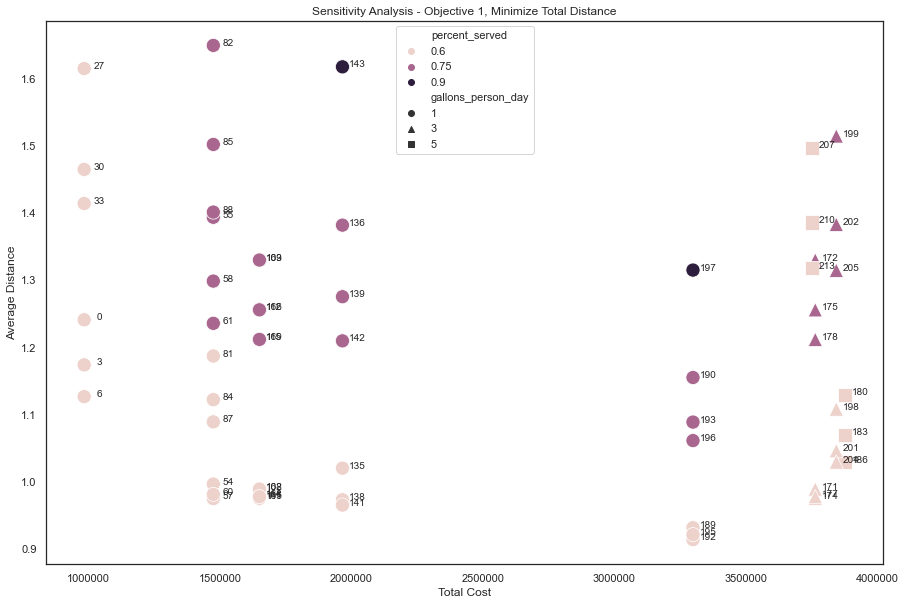

In [11]:
#plot cost vs. avg distance
sns.set(style = "white", rc = {'figure.figsize':(15, 10)})

fig, ax = plt.subplots()

sns.scatterplot(data = graph_sa, x = 'cost', y = 'distavg', hue = 'percent_served', 
                style = 'gallons_person_day', s = 200, markers = ['o', '^', 's'], legend = 'full')

plt.ticklabel_format(style = 'plain', axis = 'x')

plt.title('Sensitivity Analysis - Objective 1, Minimize Total Distance')
plt.xlabel('Total Cost')
plt.ylabel('Average Distance')
plt.legend(loc = 'upper center')

for i in range(len(graph_sa['key'])):
    plt.annotate(str(graph_sa['key'].iloc[i]), 
                 (graph_sa['cost'].iloc[i], graph_sa['distavg'].iloc[i]),
                 textcoords = "offset points",
                 xytext = (15, 0),
                 ha = 'center',
                 size = 10)
        
plt.show()

### Visualize Allegheny County Map With Water Plan

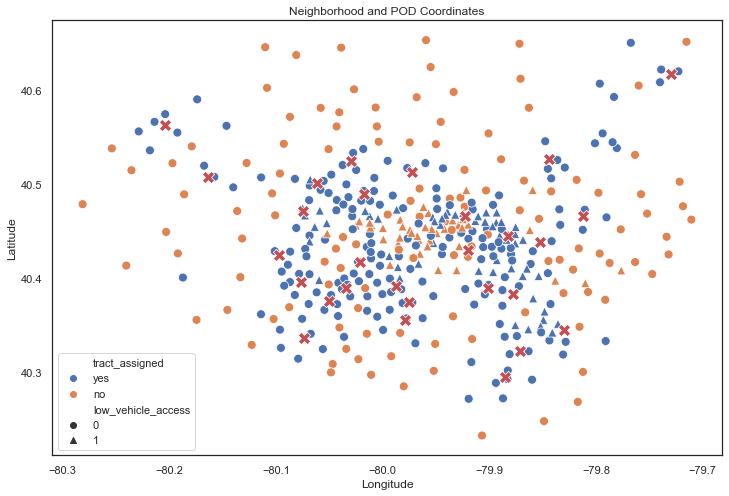

In [12]:
# low cost, low distance, 60% served
results = pods_with_budget[6]

##prep data for plot
#pods built
[pod_results] = list(results[6].values())
graph_pods = pd.DataFrame(pod_results).set_index(0).join(pod_coords, how = 'inner').reset_index(drop = True)

#neighborhoods served
[dl] = list(results[8].values())
tract_results = [i[0] for i in dl]
graph_tracts = (pd.DataFrame(tract_results).set_index(0)).merge(tract_coords, 
                                                                how = 'right', 
                                                                left_index = True, 
                                                                right_index = True, 
                                                                indicator = True)

def tract_assign(r):
    if r['_merge'] == 'right_only':
        return 'no'
    if r['_merge'] == 'both':
        return 'yes'
graph_tracts['tract_assigned'] = graph_tracts.apply(tract_assign, axis = 1)

##plot
sns.set(style = "white", rc = {'figure.figsize':(12,8)})

fig, ax = plt.subplots()

sns.scatterplot(data = graph_tracts, x = 'intptlong', y = 'intptlat', hue = 'tract_assigned', 
                hue_order = ['yes', 'no'], style = 'low_vehicle_access', markers = ['o', '^'], ax = ax, s = 80)
sns.scatterplot(data = graph_pods, x = 'long', y = 'lat', marker = 'X', ax = ax, color = 'r', s = 150)

plt.title('Neighborhood and POD Coordinates')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

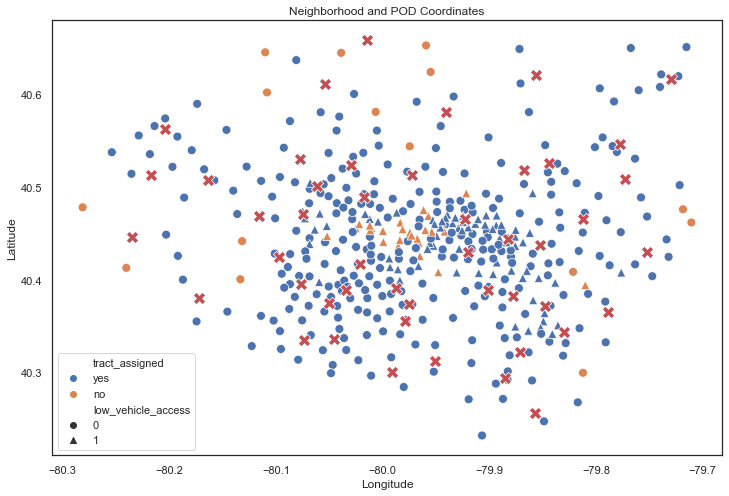

In [13]:
# high cost, med avg distance, 90% served
results = pods_with_budget[197]

##prep data for plot
#pods built
[pod_results] = list(results[6].values())
graph_pods = pd.DataFrame(pod_results).set_index(0).join(pod_coords, how = 'inner').reset_index(drop = True)

#neighborhoods served
[dl] = list(results[8].values())
tract_results = [i[0] for i in dl]
graph_tracts = (pd.DataFrame(tract_results).set_index(0)).merge(tract_coords, 
                                                                how = 'right', 
                                                                left_index = True, 
                                                                right_index = True, 
                                                                indicator = True)

def tract_assign(r):
    if r['_merge'] == 'right_only':
        return 'no'
    if r['_merge'] == 'both':
        return 'yes'
graph_tracts['tract_assigned'] = graph_tracts.apply(tract_assign, axis = 1)

##plot
sns.set(style = "white", rc = {'figure.figsize':(12,8)})

fig, ax = plt.subplots()

sns.scatterplot(data = graph_tracts, x = 'intptlong', y = 'intptlat', hue = 'tract_assigned',
                hue_order = ['yes', 'no'], style = 'low_vehicle_access', markers = ['o', '^'], ax = ax, s = 80)
sns.scatterplot(data = graph_pods, x = 'long', y = 'lat', marker = 'X', ax = ax, color = 'r', s = 150)

plt.title('Neighborhood and POD Coordinates')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

### Visualize Travel Distances

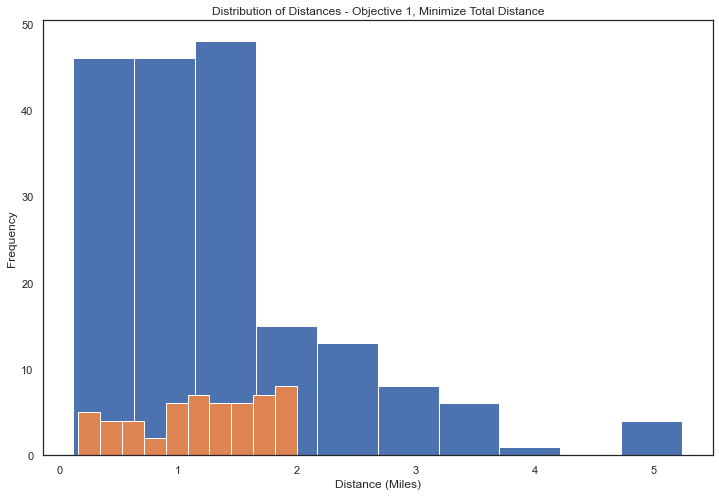

In [14]:
# low cost, low distance, 60% served
results = pods_with_budget[6]

#tracts
[dl] = list(results[8].values())
tract_results = [i[0] for i in dl]
#distances
[dist_results] = list(results[10].values())

graph_tracts_td = (pd.DataFrame({'tract': tract_results, 
                               'dist': dist_results})).merge(tract_coords[['low_vehicle_access']], 
                                                             how = 'left', 
                                                             left_on = 'tract', 
                                                             right_index = True, 
                                                             indicator = True)

plt.figure()

plt.hist(graph_tracts_td[graph_tracts_td['low_vehicle_access'] == 0]['dist'])
plt.hist(graph_tracts_td[graph_tracts_td['low_vehicle_access'] == 1]['dist'])

plt.title('Distribution of Distances - Objective 1, Minimize Total Distance')
plt.xlabel('Distance (Miles)')
plt.ylabel('Frequency')

plt.show()

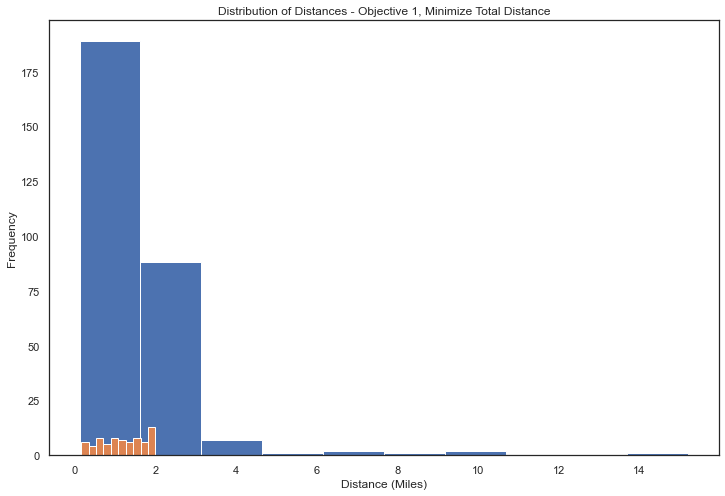

In [15]:
# high cost, med avg distance, 90% served
results = pods_with_budget[197]

#tracts
[dl] = list(results[8].values())
tract_results = [i[0] for i in dl]
#distances
[dist_results] = list(results[10].values())

graph_tracts_td = (pd.DataFrame({'tract': tract_results, 
                               'dist': dist_results})).merge(tract_coords[['low_vehicle_access']], 
                                                             how = 'left', 
                                                             left_on = 'tract', 
                                                             right_index = True, 
                                                             indicator = True)

plt.figure()

plt.hist(graph_tracts_td[graph_tracts_td['low_vehicle_access'] == 0]['dist'])
plt.hist(graph_tracts_td[graph_tracts_td['low_vehicle_access'] == 1]['dist'])

plt.title('Distribution of Distances - Objective 1, Minimize Total Distance')
plt.xlabel('Distance (Miles)')
plt.ylabel('Frequency')

plt.show()

## Objective #2

Set variables to iterate through & container for the results

In [16]:
#set the upper bound for the transportation equity constraint
upper_bound_mileages = [1, 1.5, 2.0]

#set constraint for percentage of households served
percent_served = [0.6, 0.75, 0.9]

Add Constraints & Optimize in a Loop 

In [17]:
#set a value to hold iteration that we are in:
iteration = 0
pods_with_budget_2 = {}
results = []

for iteration_budget in budget: 
    for iteration_pod_cost in pod_costs: 
        for iteration_bound_mileage in upper_bound_mileages: 
            for iteration_percent_served in percent_served: 
                
                #print iteration
                print('Iteration:', iteration)
                
                
                ### --------------- SET UP MODEL --------------- ###
                
                #set model object
                m = Model("minTotal")
                m.Params.TimeLimit = 30 # time limit of 30 seconds

                #decision variables (first-stage): number of pods
                p = m.addVar(lb = 0.0, vtype = GRB.INTEGER)

                #decision variables (second-stage): build pods, assign tracts
                x = m.addVars(pods, vtype = GRB.BINARY)
                y = m.addVars(census_tracts, pods, vtype = GRB.BINARY)
                
                # add variable z to minimize
                z = m.addVar()
               
                #objective function
                m.setObjective(z, GRB.MINIMIZE)
                
                #define pod capacity
                hh_capacity = hh_cap_dict[iteration_pod_cost]['hh_capacity']                
                gallons_person_day = hh_cap_dict[iteration_pod_cost]['gallons_person_day']

                ### add constraints ###

                # new constraint defining z
                for i in census_tracts:
                    for j in pods:
                        m.addConstr(z >= (distance[i,j] * y[i,j]))
                
                # Cost Constraint for # of PODS
                m.addConstr(iteration_pod_cost * p <= iteration_budget) 

                #Can't Use More PODS than are built
                m.addConstr(sum(x[j] for j in pods) <= p)

                #Can't Build More PODS than exist
                m.addConstr(p <= num_pods)  

                #Can Only Send Households to PODs that are built
                for i in census_tracts:
                    for j in pods:
                        m.addConstr(y[i,j] <= x[j])

                #A Certain % of Neighborhoods Need to be Served
                m.addConstr(sum(sum(y[i,j] for i in census_tracts) for j in pods)  >= iteration_percent_served * num_census_tracts)

                # Each tract is assigned to 1 or 0 PODs
                for i in census_tracts:
                    m.addConstr(sum(y[i,j] for j in pods) <= 1)

                #Each POD can only serve a certain number of households
                for j in pods:
                    m.addConstr(sum(households[i] * y[i,j] for i in census_tracts) <= hh_capacity * x[j])

                #If a census tract has limited transportation access, its residents can only travel a set distance
                for i in census_tracts:
                    for j in pods:
                        m.addConstr(distance[i,j] * y[i,j] * L[i] <= iteration_bound_mileage)

                        
                ### --------------- OPTIMIZE THE MODEL --------------- ###
                m.optimize()


                ### --------------- STORE THE RESULTS ----------------- ###

                if m.status == 2:

                    num_pods_built = p.x 
                    pods_built = []
                    for j in pods:
                        if x[j].x == 1.0:
                            pods_built.append(j)

                    tracts_served = []
                    num_tracts_served = 0
                    for i in census_tracts:
                        for j in pods:
                            if y[i,j].x == 1.0:
                                num_tracts_served += 1
                                tracts_served.append((i,j))
                    
                    max_dist = m.ObjVal
                                
                    total_dist = 0                   
                    dist_list = []
                    for i in census_tracts:
                        for j in pods:
                            if y[i,j].x == 1:
                                dist_list.append(distance[i,j])
                                total_dist += distance[i,j] * households[i]
                    
                    total_cost = num_pods_built * iteration_pod_cost 
                    
                    hh_served = []
                    num_hh_served = 0
                    for i in census_tracts:
                        for j in pods:
                            if y[i,j].x == 1.0:
                                hh_served.append(households[i])
                                num_hh_served += households[i]
                    
                    total_dist_per_hh = total_dist / num_hh_served

                    results.append({"num_pods_built": num_pods_built})
                    results.append({"iteration_budget": iteration_budget})
                    results.append({"iteration_pod_cost": iteration_pod_cost})
                    results.append({"iteration_bound_mileage": iteration_bound_mileage})
                    results.append({"iteration_percent_served": iteration_percent_served})
                    results.append({"hh_capacity": hh_capacity})
                    results.append({"pods_built": pods_built})
                    results.append({"num_tracts_served": num_tracts_served})                    
                    results.append({"tracts_served": tracts_served})
                    results.append({"total_dist": total_dist})        
                    results.append({"dist_list": dist_list})   
                    results.append({"total_dist_per_hh": total_dist_per_hh})                    
                    results.append({"total_cost": total_cost})                  
                    results.append({"gallons_person_day": gallons_person_day})
                    results.append({'model_status':'Optimal'})                    
                    results.append({'max_dist': max_dist})

                    pods_with_budget_2[iteration] = results

                elif m.status == 3:
                    
                    results.append({"num_pods_built": None})
                    results.append({"iteration_budget": iteration_budget})
                    results.append({"iteration_pod_cost": iteration_pod_cost})
                    results.append({"iteration_bound_mileage": iteration_bound_mileage})
                    results.append({"iteration_percent_served": iteration_percent_served})
                    results.append({"hh_capacity": None})
                    results.append({"pods_built": None})
                    results.append({"num_tracts_served": None})
                    results.append({"tracts_served": None})
                    results.append({"total_dist": None})
                    results.append({"dist_list": None})   
                    results.append({"total_dist_per_hh": None})
                    results.append({"total_cost": None})
                    results.append({"gallons_person_day": None})
                    results.append({'model_status':'Infeasible'})
                    results.append({'max_dist': None})
                    
                    pods_with_budget_2[iteration] = results  
                    
                else:
                    
                    results.append({"num_pods_built": None})
                    results.append({"iteration_budget": iteration_budget})
                    results.append({"iteration_pod_cost": iteration_pod_cost})
                    results.append({"iteration_bound_mileage": iteration_bound_mileage})
                    results.append({"iteration_percent_served": iteration_percent_served})
                    results.append({"hh_capacity": None})
                    results.append({"pods_built": None})
                    results.append({"num_tracts_served": None})
                    results.append({"tracts_served": None})
                    results.append({"total_dist": None})
                    results.append({"dist_list": None})   
                    results.append({"total_dist_per_hh": None})
                    results.append({"total_cost": None})
                    results.append({"gallons_person_day": None})
                    results.append({'model_status':'Not Solved'})
                    results.append({'max_dist': None})
                    
                    pods_with_budget_2[iteration] = results

                ### --------------- PREP FOR NEXT ITERATION --------------- ###
                #clear old results before the beginning of the next iteration
                results = []
                #update the iteration number
                iteration += 1

Iteration: 0
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 57135 rows, 18943 columns and 136350 nonzeros
Model fingerprint: 0x40798e11
Variable types: 1 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [1e-01, 4e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 27999 rows and 4482 columns
Presolve time: 0.36s
Presolved: 29136 rows, 14461 columns, 100393 nonzeros
Variable types: 0 continuous, 14461 integer (14460 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   33432    2.8382278e+00   0.000000e+00   4.419677e+00      5s
   40762    3.4654989e-01  

Optimize a model with 57135 rows, 18943 columns and 136350 nonzeros
Model fingerprint: 0xb2b05328
Variable types: 1 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [1e-01, 4e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 27800 rows and 4400 columns
Presolve time: 0.48s
Presolved: 29335 rows, 14543 columns, 100956 nonzeros
Variable types: 0 continuous, 14543 integer (14542 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   34708    4.6867177e+00   0.000000e+00   1.948420e+01      5s
   40822    4.0880015e-01   0.000000e+00   1.221713e+00     10s
   45410    2.1010780e-01   0.000000e+00   5.909086e-02     15s
   47909    1.6665421e-01   0.000000e+00   1.562378e-02     20s
   49660    1.5212811e-01   0.000000e+00   9.844878e-03     25s
   5062

Presolve removed 27953 rows and 4482 columns
Presolve time: 0.04s

Explored 0 nodes (0 simplex iterations) in 0.07 seconds
Thread count was 1 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 12
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 57135 rows, 18943 columns and 136350 nonzeros
Model fingerprint: 0x05a06999
Variable types: 1 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [1e-01, 8e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 27941 rows and 4456 columns
Presolve time: 0.45s
Presolved: 29194 rows, 14487 columns, 100561 nonzeros
Variable types: 0 continuous, 14487 integer (14486 binary)

Deterministic concu

Concurrent spin time: 0.00s

Solved with primal simplex

Root relaxation: infeasible, 53321 iterations, 15.09 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasible    0               - infeasible      -     -   15s

Explored 0 nodes (53321 simplex iterations) in 15.70 seconds
Thread count was 8 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 18
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 57135 rows, 18943 columns and 136350 nonzeros
Model fingerprint: 0xd7fd745a
Variable types: 1 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+05]
  Objective range

  RHS range        [1e+00, 1e+06]
Presolve removed 27800 rows and 4400 columns
Presolve time: 0.37s
Presolved: 29335 rows, 14543 columns, 100956 nonzeros
Variable types: 0 continuous, 14543 integer (14542 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   34972    1.2266260e-02   1.528576e+06   0.000000e+00      5s
   44972    0.0000000e+00   1.936000e+03   2.106813e+09      9s
   68420    0.0000000e+00   1.935723e+03   5.415210e+08     10s
   81923    1.2950063e-01   1.263834e+03   3.078430e+08     15s
   86256    3.7701982e-01   1.057519e+03   4.509377e+07     20s
Concurrent spin time: 3.43s

Solved with dual simplex

Root relaxation: infeasible, 26336 iterations, 21.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasibl

Model fingerprint: 0xf8bf9ba6
Variable types: 1 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [1e-01, 7e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 27941 rows and 4456 columns
Presolve time: 0.39s
Presolved: 29194 rows, 14487 columns, 100561 nonzeros
Variable types: 0 continuous, 14487 integer (14486 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   33389    8.4214545e+00   0.000000e+00   7.764191e+00      5s
   40778    9.8876291e-01   0.000000e+00   6.727495e+01     10s
   45819    3.2492921e-01   0.000000e+00   1.573847e-01     15s
   48909    2.1237437e-01   0.000000e+00   4.479562e-02     20s
   51072    1.8041477e-01   0.000000e+00   1.119579e-01     25s
   52899    1.6417373e-01   0.000000e+00   7.464550e-03     30s
Concurrent 


Explored 0 nodes (49216 simplex iterations) in 12.94 seconds
Thread count was 8 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 36
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 57135 rows, 18943 columns and 136350 nonzeros
Model fingerprint: 0x7f8fbdce
Variable types: 1 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [1e-01, 2e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 27999 rows and 4482 columns
Presolve time: 0.40s
Presolved: 29136 rows, 14461 columns, 100393 nonzeros
Variable types: 0 continuous, 14461 integer (14460 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log

Model fingerprint: 0xcb6bbabc
Variable types: 1 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [1e-01, 2e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 27800 rows and 4400 columns
Presolve time: 0.41s
Presolved: 29335 rows, 14543 columns, 100956 nonzeros
Variable types: 0 continuous, 14543 integer (14542 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   38227    3.2649479e-04   3.436558e+04   0.000000e+00      5s
   43498    5.8582392e-02   9.150020e+06   0.000000e+00     10s
Concurrent spin time: 0.12s

Solved with primal simplex

Root relaxation: infeasible, 44105 iterations, 9.72 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

  Matrix range     [1e-01, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 27941 rows and 4456 columns
Presolve time: 0.35s
Presolved: 29194 rows, 14487 columns, 100561 nonzeros
Variable types: 0 continuous, 14487 integer (14486 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with primal simplex

Root relaxation: infeasible, 28657 iterations, 2.13 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasible    0               - infeasible      -     -    2s

Explored 0 nodes (28657 simplex iterations) in 2.69 seconds
Thread count was 8 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 49
Changed value of parameter TimeLimit to 30.0
   Pre

   25748    1.6152110e-01   0.000000e+00   3.533274e-02     20s
   27911    1.4479472e-01   0.000000e+00   3.678375e-02     25s
   29559    1.3390873e-01   0.000000e+00   1.783908e-02     30s


Root relaxation: time limit, 0 iterations, 29.81 seconds

Explored 0 nodes (0 simplex iterations) in 30.32 seconds
Thread count was 8 (of 8 available processors)

Solution count 0

Time limit reached
Best objective -, best bound 0.000000000000e+00, gap -
Iteration: 55
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 57135 rows, 18943 columns and 136350 nonzeros
Model fingerprint: 0x738c810f
Variable types: 1 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [1e-01, 4e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+0


Explored 0 nodes (26484 simplex iterations) in 30.21 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 28.47 

Time limit reached
Best objective 2.847000000000e+01, best bound 0.000000000000e+00, gap 100.0000%
Iteration: 61
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 57135 rows, 18943 columns and 136350 nonzeros
Model fingerprint: 0x95ef986a
Variable types: 1 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [1e-01, 4e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 27800 rows and 4400 columns
Presolve time: 0.37s
Presolved: 29335 rows, 14543 columns, 100956 nonzeros
Variable types: 0 continuous, 14543 integer (14542 binary)

Deterministic concurrent LP opt


Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 67
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 57135 rows, 18943 columns and 136350 nonzeros
Model fingerprint: 0x6cccd46d
Variable types: 1 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [1e-01, 8e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 27941 rows and 4456 columns
Presolve time: 0.37s
Presolved: 29194 rows, 14487 columns, 100561 nonzeros
Variable types: 0 continuous, 14487 integer (14486 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with primal simplex

Root relaxation: infeasible, 35441 iterati

  Matrix range     [1e-01, 1e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 27999 rows and 4482 columns
Presolve time: 0.36s
Presolved: 29136 rows, 14461 columns, 100393 nonzeros
Variable types: 0 continuous, 14461 integer (14460 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   30627    1.0613540e-03   1.770184e+06   0.000000e+00      5s
   37832    1.1592730e+01   7.339066e+08   0.000000e+00     10s
Concurrent spin time: 0.00s

Solved with primal simplex

Root relaxation: infeasible, 37843 iterations, 9.48 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasible    0               - infeasible      -     -   10s

Explored 0 nodes (37843 simplex ite


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasible    0               - infeasible      -     -    6s

Explored 0 nodes (38401 simplex iterations) in 6.23 seconds
Thread count was 8 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 80
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 57135 rows, 18943 columns and 136350 nonzeros
Model fingerprint: 0x4d0f9f45
Variable types: 1 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 27800 rows and 44


Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   11654    7.0946883e-01   0.000000e+00   6.872979e-01      5s
   15465    3.2512437e-01   0.000000e+00   1.320818e-01     10s
   18040    2.4034088e-01   0.000000e+00   1.114775e-01     15s
   20409    1.9612922e-01   0.000000e+00   9.209011e-02     20s
   22041    1.7443550e-01   0.000000e+00   0.000000e+00     25s
Concurrent spin time: 1.80s

Solved with primal simplex

Root relaxation: objective 1.744355e-01, 22041 iterations, 26.28 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.17444    0 11989          -    0.17444      -     -   30s

Explored 0 nodes (25150 simplex iterations) in 30.07 seconds
Thread count was 8 (of 8 available processors)

Solution count 0

Time limit reache


     0     0 infeasible    0               - infeasible      -     -    7s

Explored 0 nodes (44363 simplex iterations) in 7.58 seconds
Thread count was 8 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 91
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 57135 rows, 18943 columns and 136350 nonzeros
Model fingerprint: 0xf767faaf
Variable types: 1 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [1e-01, 2e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 27999 rows and 4482 columns
Presolve time: 0.38s
Presolved: 29136 rows, 14461 columns, 100393 nonzeros
Variable types: 0 continuous, 14461 integer (14460 binary)

Deter

Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 57135 rows, 18943 columns and 136350 nonzeros
Model fingerprint: 0xc49228fc
Variable types: 1 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [1e-01, 2e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 27800 rows and 4400 columns
Presolve time: 0.40s
Presolved: 29335 rows, 14543 columns, 100956 nonzeros
Variable types: 0 continuous, 14543 integer (14542 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   37792    0.0000000e+00   4.376394e+03   0.000000e+00      5s
   44100    8.1717431e-01   3.591476e+07   0.000000e+00     10s
Concurrent spin time: 0.00s

Solved with primal simplex

Root relaxation: infeasible, 47063 iterations, 10.64 seconds

    

Thread count was 8 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 103
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 57135 rows, 18943 columns and 136350 nonzeros
Model fingerprint: 0x37387e58
Variable types: 1 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [1e-01, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 27941 rows and 4456 columns
Presolve time: 0.38s
Presolved: 29194 rows, 14487 columns, 100561 nonzeros
Variable types: 0 continuous, 14487 integer (14486 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with primal sim


Cutting planes:
  Gomory: 40
  RLT: 1
  Relax-and-lift: 184

Explored 1 nodes (17991 simplex iterations) in 30.96 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 1.9 4.5 

Time limit reached
Best objective 1.900000000000e+00, best bound 1.200000000000e-01, gap 93.6842%
Iteration: 109
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 57135 rows, 18943 columns and 136350 nonzeros
Model fingerprint: 0xfa68a360
Variable types: 1 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [1e-01, 4e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 42413 rows and 4529 columns
Presolve time: 0.12s
Presolved: 14722 rows, 14414 columns, 71473 nonzeros
Variable types: 0 continuous,

   16287    1.1801099e-01   0.000000e+00   2.296125e-03     20s
   16550    1.1695954e-01   0.000000e+00   0.000000e+00     22s

Root relaxation: objective 1.169595e-01, 16550 iterations, 21.63 seconds
Total elapsed time = 25.82s

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.11696    0 14162          -    0.11696      -     -   28s
H    0     0                       6.4100000    0.11696  98.2%     -   28s
H    0     0                       1.6900000    0.11696  93.1%     -   29s

Cutting planes:
  Zero half: 4

Explored 1 nodes (17771 simplex iterations) in 30.03 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 1.69 6.41 

Time limit reached
Best objective 1.690000000000e+00, best bound 1.200000000000e-01, gap 92.8994%
Iteration: 115
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimize

Showing first log only...

Concurrent spin time: 0.01s

Solved with primal simplex

Root relaxation: infeasible, 35718 iterations, 3.90 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasible    0               - infeasible      -     -    4s

Explored 0 nodes (35718 simplex iterations) in 4.40 seconds
Thread count was 8 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 121
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 57135 rows, 18943 columns and 136350 nonzeros
Model fingerprint: 0x0f2c08dd
Variable types: 1 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [1e-01

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasible    0               - infeasible      -     -    3s

Explored 0 nodes (31111 simplex iterations) in 3.78 seconds
Thread count was 8 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 127
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 57135 rows, 18943 columns and 136350 nonzeros
Model fingerprint: 0x803a9cf8
Variable types: 1 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 27999 rows and 4482 columns
Presolve time: 0.36s
Presolved: 29136 rows, 14461 columns, 100


Solved with primal simplex

Root relaxation: infeasible, 36317 iterations, 4.11 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasible    0               - infeasible      -     -    4s

Explored 0 nodes (36317 simplex iterations) in 4.64 seconds
Thread count was 8 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 134
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 57135 rows, 18943 columns and 136350 nonzeros
Model fingerprint: 0x7baf52c9
Variable types: 1 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+05]
  Objective range  [1e+00, 1e+00]
  Bounds ran

Thread count was 8 (of 8 available processors)

Solution count 0

Time limit reached
Best objective -, best bound 1.200000000000e-01, gap -
Iteration: 139
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 57135 rows, 18943 columns and 136350 nonzeros
Model fingerprint: 0x20ef04b8
Variable types: 1 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [1e-01, 7e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 27941 rows and 4456 columns
Presolve time: 0.37s
Presolved: 29194 rows, 14487 columns, 100561 nonzeros
Variable types: 0 continuous, 14487 integer (14486 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    


Explored 1 nodes (100116 simplex iterations) in 30.01 seconds
Thread count was 8 (of 8 available processors)

Solution count 5: 14.29 14.3 14.31 ... 14.33

Time limit reached
Best objective 1.429000000000e+01, best bound 1.070000000000e+00, gap 92.5122%
Iteration: 144
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 57135 rows, 18943 columns and 136350 nonzeros
Model fingerprint: 0xfb3f7ec9
Variable types: 1 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [1e-01, 2e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 27999 rows and 4482 columns
Presolve time: 0.36s
Presolved: 29136 rows, 14461 columns, 100393 nonzeros
Variable types: 0 continuous, 14461 integer (14460 binary)

Determinis

Variable types: 1 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [1e-01, 2e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 27800 rows and 4400 columns
Presolve time: 0.35s
Presolved: 29335 rows, 14543 columns, 100956 nonzeros
Variable types: 0 continuous, 14543 integer (14542 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   35577    7.0274800e+00   0.000000e+00   5.159939e+02      5s
   42253    1.0127666e+00   0.000000e+00   8.426189e-01     10s
   46373    5.8862784e-01   0.000000e+00   1.441773e+00     15s
   47553    5.7883104e-01   0.000000e+00   0.000000e+00     17s
Concurrent spin time: 0.00s

Solved with primal simplex

Root relaxation: objective 5.788310e-01, 47553 iterations, 16.32 seconds
Total elapsed time = 24.04s
Total elaps

Presolve time: 0.04s

Explored 0 nodes (0 simplex iterations) in 0.06 seconds
Thread count was 1 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 156
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 57135 rows, 18943 columns and 136350 nonzeros
Model fingerprint: 0xa6439bb6
Variable types: 1 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [1e-01, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 27941 rows and 4456 columns
Presolve time: 0.35s
Presolved: 29194 rows, 14487 columns, 100561 nonzeros
Variable types: 0 continuous, 14487 integer (14486 binary)

Deterministic concurrent LP optimizer: primal and dual simplex



Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 162
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 57135 rows, 18943 columns and 136350 nonzeros
Model fingerprint: 0x5ef25ff3
Variable types: 1 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [1e-01, 4e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+06]
Presolve removed 42413 rows and 4529 columns
Presolve time: 0.12s
Presolved: 14722 rows, 14414 columns, 71473 nonzeros
Variable types: 0 continuous, 14414 integer (14413 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   10472    3.3509857e-01   1.750209e+02   0.000000e+00      5s
   13475    1.4248255e-01   0.000000e+00

Iteration: 167
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 57135 rows, 18943 columns and 136350 nonzeros
Model fingerprint: 0x02b523d1
Variable types: 1 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [1e-01, 4e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+06]
Presolve removed 42335 rows and 4503 columns
Presolve time: 0.05s

Explored 0 nodes (0 simplex iterations) in 0.07 seconds
Thread count was 1 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 168
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 lo

   10217    4.2115141e-01   2.365177e+03   0.000000e+00      5s
   13006    4.3806904e-01   1.210265e+03   0.000000e+00     10s
   17922    1.8019486e-01   0.000000e+00   1.974357e-02     15s
   18024    1.7968777e-01   0.000000e+00   0.000000e+00     15s

Root relaxation: objective 1.796878e-01, 18024 iterations, 15.25 seconds
Total elapsed time = 23.47s
Total elapsed time = 25.72s

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.17969    0 12144          -    0.17969      -     -   27s
H    0     0                       5.8700000    0.17969  96.9%     -   27s
H    0     0                       5.8500000    0.17969  96.9%     -   27s

Cutting planes:
  Gomory: 88
  Zero half: 13

Explored 1 nodes (44167 simplex iterations) in 49.97 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 5.85 5.87 

Time limit reached
Best objective 5.850000000000e+

Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 57135 rows, 18943 columns and 136350 nonzeros
Model fingerprint: 0x0f359c7f
Variable types: 1 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [1e-01, 8e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+06]
Presolve removed 42296 rows and 4447 columns
Presolve time: 0.13s
Presolved: 14839 rows, 14496 columns, 71872 nonzeros
Variable types: 0 continuous, 14496 integer (14495 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   10506    4.3863626e-01   1.811499e+03   0.000000e+00      5s
   13394    4.5334908e-01   3.305196e+03   0.000000e+00     10s
   18283    1.6869673e-01   0.000000e+00   2.004680e-01     15s
   18982    1.6641588e-01   0.000000e+00   0.000000e+00     18s

Root relaxation: objective 1.664159e-01, 18982 iterations, 17.71 seconds
Total elapsed

Best objective -, best bound 0.000000000000e+00, gap -
Iteration: 184
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 57135 rows, 18943 columns and 136350 nonzeros
Model fingerprint: 0x57b1d6f0
Variable types: 1 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+06]
Presolve removed 27941 rows and 4456 columns
Presolve time: 0.36s
Presolved: 29194 rows, 14487 columns, 100561 nonzeros
Variable types: 0 continuous, 14487 integer (14486 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with primal simplex

Root relaxation: infeasible, 36107 iterations, 3.86 seconds

  


Solution count 1: 1.69 

Time limit reached
Best objective 1.690000000000e+00, best bound 1.200000000000e-01, gap 92.8994%
Iteration: 190
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 57135 rows, 18943 columns and 136350 nonzeros
Model fingerprint: 0xba4ade7f
Variable types: 1 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [1e-01, 7e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+06]
Presolve removed 42413 rows and 4529 columns
Presolve time: 0.13s
Presolved: 14722 rows, 14414 columns, 71473 nonzeros
Variable types: 0 continuous, 14414 integer (14413 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   10663    4.3064969e-01   1.513977e+03   0.000000e+00  

Iteration: 194
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 57135 rows, 18943 columns and 136350 nonzeros
Model fingerprint: 0x424c3235
Variable types: 1 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [1e-01, 7e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+06]
Presolve removed 42335 rows and 4503 columns
Presolve time: 0.04s

Explored 0 nodes (0 simplex iterations) in 0.06 seconds
Thread count was 1 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 195
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 lo

H    0     0                       5.5200000    0.68000  87.7%     -   14s
     0     0    1.15456    0  556    5.52000    1.15456  79.1%     -   19s
H    0     0                       5.4900000    1.15456  79.0%     -   20s
H    0     0                       5.4800000    1.15456  78.9%     -   20s
     0     0    1.54481    0  654    5.48000    1.54481  71.8%     -   20s
H    0     0                       5.2100000    1.54481  70.3%     -   20s
H    0     0                       5.1900000    1.54481  70.2%     -   20s
H    0     0                       5.1100000    1.54481  69.8%     -   20s
H    0     0                       5.0800000    1.54481  69.6%     -   20s
H    0     0                       3.8800000    1.54481  60.2%     -   20s
H    0     0                       3.2500000    1.54481  52.5%     -   20s
H    0     0                       3.2000000    1.54481  51.7%     -   20s
H    0     0                       2.9500000    1.70000  42.4%     -   20s
     0     0    2.39468  

Thread count was 8 (of 8 available processors)

Solution count 0

Time limit reached
Best objective -, best bound 1.200000000000e-01, gap -
Iteration: 202
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 57135 rows, 18943 columns and 136350 nonzeros
Model fingerprint: 0xc871db4d
Variable types: 1 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [1e-01, 2e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+06]
Presolve removed 27941 rows and 4456 columns
Presolve time: 0.36s
Presolved: 29194 rows, 14487 columns, 100561 nonzeros
Variable types: 0 continuous, 14487 integer (14486 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    

Variable types: 1 continuous, 18942 integer (18941 binary)
Coefficient statistics:
  Matrix range     [1e-01, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+06]
Presolve removed 27999 rows and 4482 columns
Presolve time: 0.37s
Presolved: 29136 rows, 14461 columns, 100393 nonzeros
Variable types: 0 continuous, 14461 integer (14460 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   37718    1.3159971e+01   0.000000e+00   1.411913e+03      5s
   43893    8.6112786e-01   0.000000e+00   7.654654e+01     10s
   49246    3.3712123e-01   0.000000e+00   1.336096e-01     15s
   52781    2.0155597e-01   0.000000e+00   3.779038e-02     20s
   54944    1.6297291e-01   0.000000e+00   2.329435e-02     25s
   56592    1.4740940e-01   0.000000e+00   2.840006e-02     30s


Root relaxation: time limit, 0 iteratio

   11027    4.1529696e-01   0.000000e+00   8.503801e-01      5s
   14941    2.2325309e-01   0.000000e+00   8.371991e-02     10s
   17825    1.6810089e-01   0.000000e+00   3.677207e-02     15s
   19782    1.4496223e-01   0.000000e+00   3.906927e-02     20s
   21327    1.3434118e-01   0.000000e+00   4.759685e-02     25s
   22666    1.3104950e-01   0.000000e+00   4.414869e-04     30s


Root relaxation: time limit, 0 iterations, 29.56 seconds

Explored 0 nodes (0 simplex iterations) in 30.08 seconds
Thread count was 8 (of 8 available processors)

Solution count 0

Time limit reached
Best objective -, best bound 0.000000000000e+00, gap -
Iteration: 214
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 57135 rows, 18943 columns and 136350 nonzeros
Model fingerprint: 0xdfdc0371
Variable types: 1 conti

### Plot Sensitivity Analysis

In [18]:
#store results in dataframe for plotting
sa_dist = []
sa_distavg = []
sa_cost = []
sa_ps = []
sa_ga = []
sa_keys = []
for i in pods_with_budget_2:
    if list(pods_with_budget_2[i][14].values())[0] == 'Optimal':
    
        sa_keys.append(list(pods_with_budget_2.keys())[i])
    
        [sa_dist_item] = list(pods_with_budget_2[i][9].values())
        sa_dist.append(sa_dist_item)
        
        [sa_distavg_item] = list(pods_with_budget_2[i][11].values())
        sa_distavg.append(sa_distavg_item)

        [sa_cost_item] = list(pods_with_budget_2[i][12].values())
        sa_cost.append(sa_cost_item)

        [sa_ps_item] = list(pods_with_budget_2[i][4].values())
        sa_ps.append(sa_ps_item)

        [sa_ga_item] = list(pods_with_budget_2[i][13].values())
        sa_ga.append(sa_ga_item)
        
graph_sa_2 = pd.DataFrame({'key': sa_keys, 'dist': sa_dist, 'distavg': sa_distavg, 'cost': sa_cost, 
                         'percent_served': sa_ps, 'gallons_person_day': sa_ga})

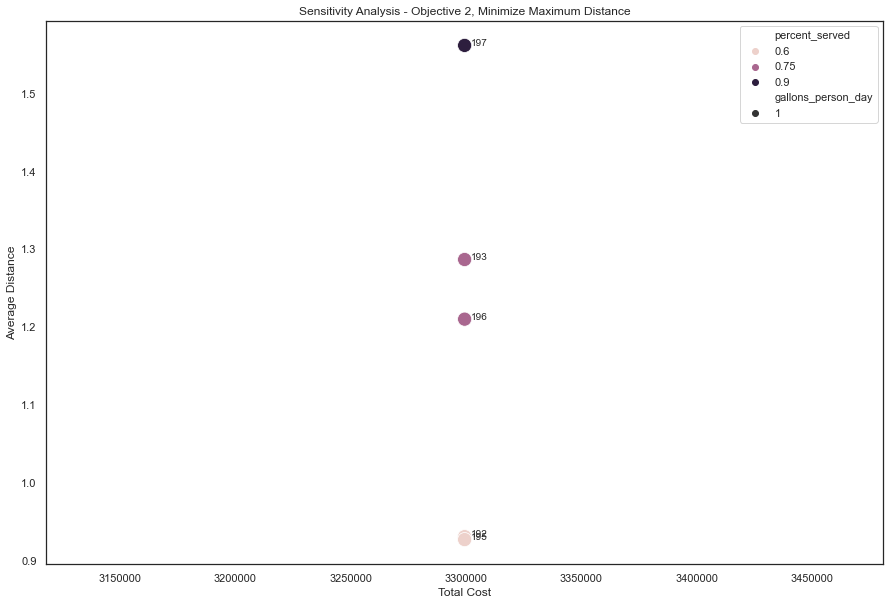

In [19]:
#plot cost vs. avg distance
sns.set(style = "white", rc = {'figure.figsize':(15, 10)})

fig, ax = plt.subplots()

sns.scatterplot(data = graph_sa_2, x = 'cost', y = 'distavg', hue = 'percent_served', 
                style = 'gallons_person_day', s = 200, markers = ['o', '^', 's'], legend = 'full')

plt.ticklabel_format(style = 'plain', axis = 'x')

plt.title('Sensitivity Analysis - Objective 2, Minimize Maximum Distance')
plt.xlabel('Total Cost')
plt.ylabel('Average Distance')

for i in range(len(graph_sa_2['key'])):
    plt.annotate(str(graph_sa_2['key'].iloc[i]), 
                 (graph_sa_2['cost'].iloc[i], graph_sa_2['distavg'].iloc[i]),
                 textcoords = "offset points",
                 xytext = (15, 0),
                 ha = 'center',
                 size = 10)
        
plt.show()

### Visualize Allegheny County Map With Water Plan

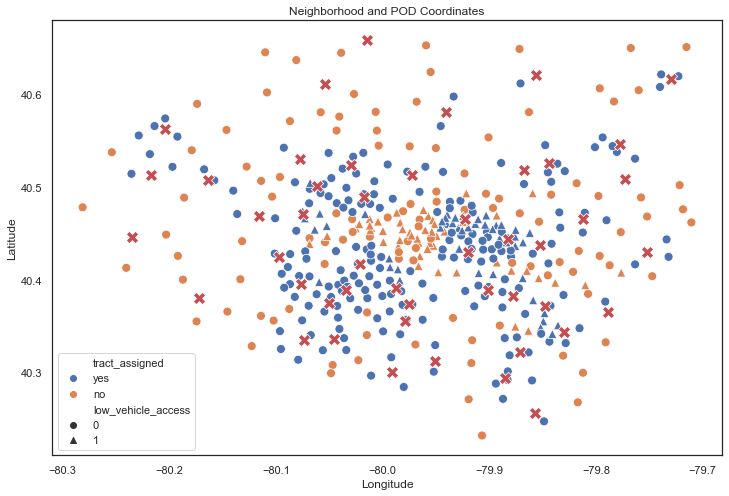

In [20]:
# low cost, low distance, 60% served
results = pods_with_budget_2[192]

##prep data for plot
#pods built
[pod_results] = list(results[6].values())
graph_pods_2 = pd.DataFrame(pod_results).set_index(0).join(pod_coords, how = 'inner').reset_index(drop = True)

#neighborhoods served
[dl] = list(results[8].values())
tract_results = [i[0] for i in dl]
graph_tracts_2 = (pd.DataFrame(tract_results).set_index(0)).merge(tract_coords, 
                                                                  how = 'right', 
                                                                  left_index = True, 
                                                                  right_index = True, 
                                                                  indicator = True)

def tract_assign(r):
    if r['_merge'] == 'right_only':
        return 'no'
    if r['_merge'] == 'both':
        return 'yes'
graph_tracts_2['tract_assigned'] = graph_tracts_2.apply(tract_assign, axis = 1)

##plot
sns.set(style = "white", rc = {'figure.figsize':(12,8)})

fig, ax = plt.subplots()

sns.scatterplot(data = graph_tracts_2, x = 'intptlong', y = 'intptlat', hue = 'tract_assigned', 
                hue_order = ['yes', 'no'], style = 'low_vehicle_access', markers = ['o', '^'], ax = ax, s = 80)
sns.scatterplot(data = graph_pods_2, x = 'long', y = 'lat', marker = 'X', ax = ax, color = 'r', s = 150)

plt.title('Neighborhood and POD Coordinates')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

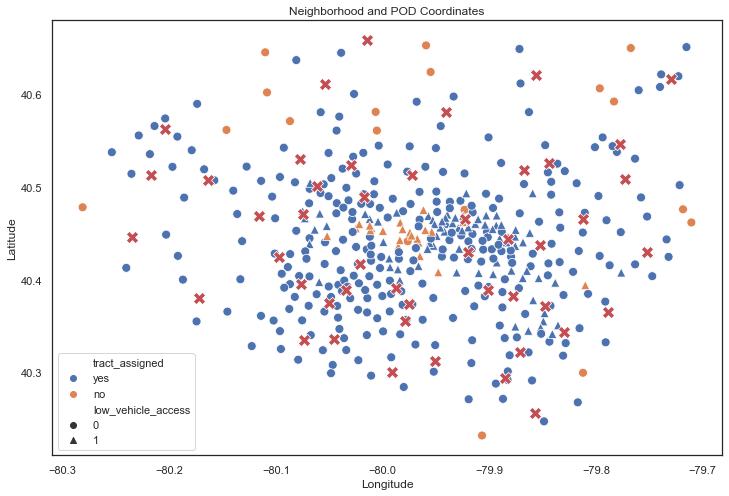

In [21]:
# high cost, high avg distance, 90% served
results = pods_with_budget_2[197]

##prep data for plot
#pods built
[pod_results] = list(results[6].values())
graph_pods_2 = pd.DataFrame(pod_results).set_index(0).join(pod_coords, how = 'inner').reset_index(drop = True)

#neighborhoods served
[dl] = list(results[8].values())
tract_results = [i[0] for i in dl]
graph_tracts_2 = (pd.DataFrame(tract_results).set_index(0)).merge(tract_coords, 
                                                                  how = 'right', 
                                                                  left_index = True, 
                                                                  right_index = True, 
                                                                  indicator = True)

def tract_assign(r):
    if r['_merge'] == 'right_only':
        return 'no'
    if r['_merge'] == 'both':
        return 'yes'
graph_tracts_2['tract_assigned'] = graph_tracts_2.apply(tract_assign, axis = 1)

##plot
sns.set(style = "white", rc = {'figure.figsize':(12,8)})

fig, ax = plt.subplots()

sns.scatterplot(data = graph_tracts_2, x = 'intptlong', y = 'intptlat', hue = 'tract_assigned',
                hue_order = ['yes', 'no'], style = 'low_vehicle_access', markers = ['o', '^'], ax = ax, s = 80)
sns.scatterplot(data = graph_pods_2, x = 'long', y = 'lat', marker = 'X', ax = ax, color = 'r', s = 150)

plt.title('Neighborhood and POD Coordinates')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

### Visualize Travel Distances

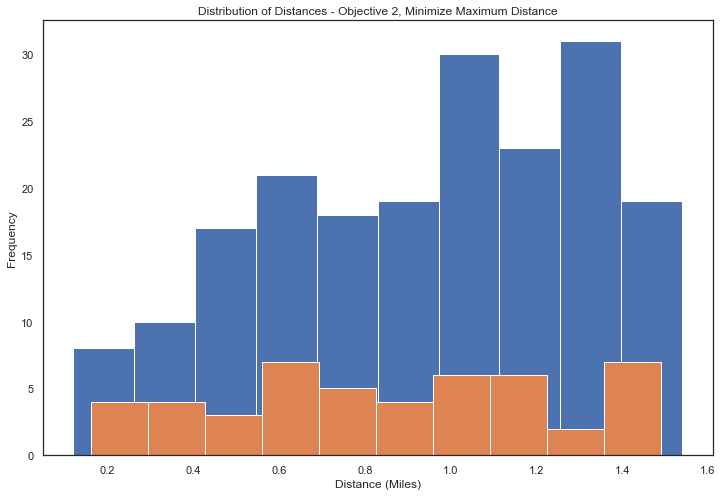

In [22]:
# low cost, low distance, 60% served
results = pods_with_budget_2[192]

#tracts
[dl] = list(results[8].values())
tract_results = [i[0] for i in dl]
#distances
[dist_results] = list(results[10].values())

graph_tracts_td_2 = (pd.DataFrame({'tract': tract_results, 
                                   'dist': dist_results})).merge(tract_coords[['low_vehicle_access']], 
                                                                 how = 'left', 
                                                                 left_on = 'tract', 
                                                                 right_index = True, 
                                                                 indicator = True)

plt.figure()

plt.hist(graph_tracts_td_2[graph_tracts_td_2['low_vehicle_access'] == 0]['dist'])
plt.hist(graph_tracts_td_2[graph_tracts_td_2['low_vehicle_access'] == 1]['dist'])

plt.title('Distribution of Distances - Objective 2, Minimize Maximum Distance')
plt.xlabel('Distance (Miles)')
plt.ylabel('Frequency')

plt.show()

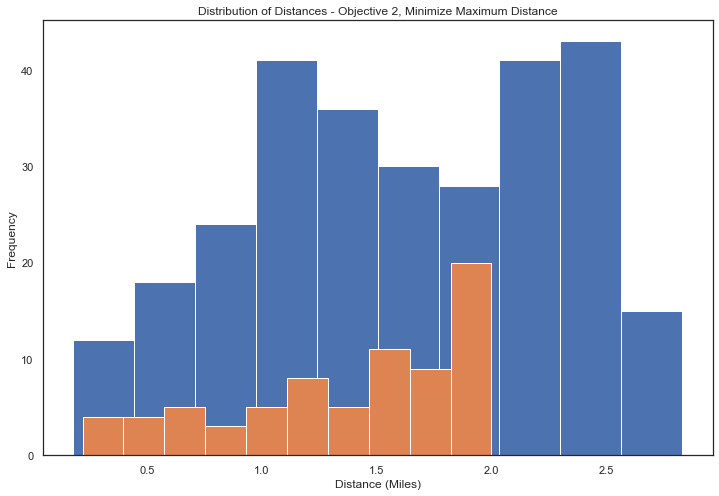

In [23]:
# high cost, high avg distance, 90% served
results = pods_with_budget_2[197]

#tracts
[dl] = list(results[8].values())
tract_results = [i[0] for i in dl]
#distances
[dist_results] = list(results[10].values())

graph_tracts_td_2 = (pd.DataFrame({'tract': tract_results, 
                                   'dist': dist_results})).merge(tract_coords[['low_vehicle_access']], 
                                                                 how = 'left', 
                                                                 left_on = 'tract', 
                                                                 right_index = True, 
                                                                 indicator = True)

plt.figure()

plt.hist(graph_tracts_td_2[graph_tracts_td_2['low_vehicle_access'] == 0]['dist'])
plt.hist(graph_tracts_td_2[graph_tracts_td_2['low_vehicle_access'] == 1]['dist'])

plt.title('Distribution of Distances - Objective 2, Minimize Maximum Distance')
plt.xlabel('Distance (Miles)')
plt.ylabel('Frequency')

plt.show()

# Compare Objectives 1 & 2

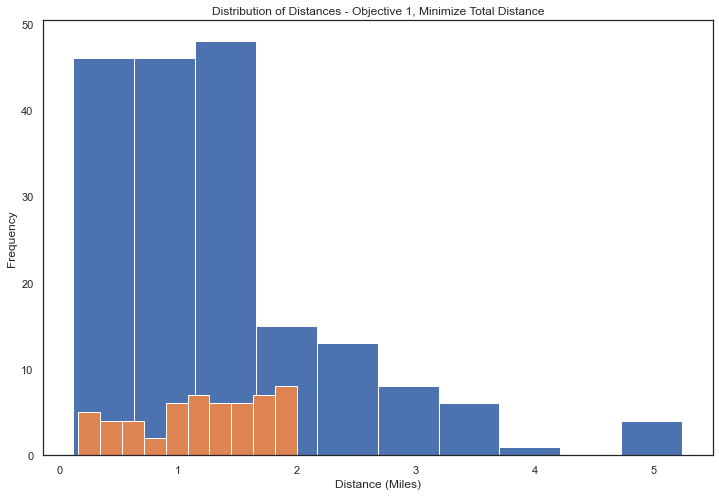

In [24]:
#Objective 1
# low cost, low distance, 60% served
results = pods_with_budget[6]

#tracts
[dl] = list(results[8].values())
tract_results = [i[0] for i in dl]
#distances
[dist_results] = list(results[10].values())

graph_tracts_td = (pd.DataFrame({'tract': tract_results, 
                                 'dist': dist_results})).merge(tract_coords[['low_vehicle_access']], 
                                                               how = 'left', 
                                                               left_on = 'tract', 
                                                               right_index = True, 
                                                               indicator = True)

plt.figure()

plt.hist(graph_tracts_td[graph_tracts_td['low_vehicle_access'] == 0]['dist'])
plt.hist(graph_tracts_td[graph_tracts_td['low_vehicle_access'] == 1]['dist'])

plt.title('Distribution of Distances - Objective 1, Minimize Total Distance')
plt.xlabel('Distance (Miles)')
plt.ylabel('Frequency')

plt.show()

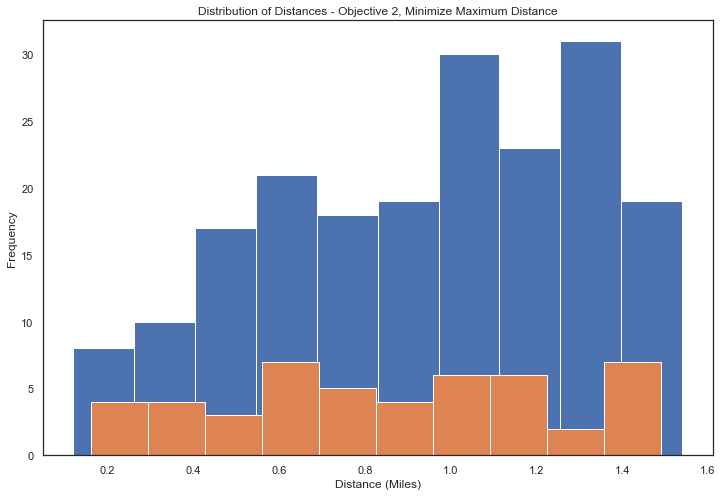

In [25]:
#Objective 2
# low cost, low distance, 60% served
results = pods_with_budget_2[192]

#tracts
[dl] = list(results[8].values())
tract_results = [i[0] for i in dl]
#distances
[dist_results] = list(results[10].values())

graph_tracts_td_2 = (pd.DataFrame({'tract': tract_results, 
                                   'dist': dist_results})).merge(tract_coords[['low_vehicle_access']], 
                                                                 how = 'left', 
                                                                 left_on = 'tract', 
                                                                 right_index = True, 
                                                                 indicator = True)

plt.figure()

plt.hist(graph_tracts_td_2[graph_tracts_td_2['low_vehicle_access'] == 0]['dist'])
plt.hist(graph_tracts_td_2[graph_tracts_td_2['low_vehicle_access'] == 1]['dist'])

plt.title('Distribution of Distances - Objective 2, Minimize Maximum Distance')
plt.xlabel('Distance (Miles)')
plt.ylabel('Frequency')

plt.show()

# Travel Equity: Add Downtown PODs, Reevaluate Objective #1

Update indices

In [26]:
# update indices
num_census_tracts = distance_full.shape[0]
num_pods_full = distance_full.shape[1] 

census_tracts = range(num_census_tracts)
pods_full = range(num_pods_full)

Set variables to iterate through & container for the results

In [27]:
#set the upper bound for the transportation equity constraint
upper_bound_mileages = [1, 1.5, 2.0]

#set constraint for percentage of households served
percent_served = [0.6, 0.75, 0.9]

Add Constraints & Optimize in a Loop 

In [28]:
#set a value to hold iteration that we are in:
iteration = 0
pods_with_budget_3 = {}
results = []

for iteration_budget in budget: 
    for iteration_pod_cost in pod_costs: 
        for iteration_bound_mileage in upper_bound_mileages: 
            for iteration_percent_served in percent_served: 
                
                #print iteration
                print('Iteration:', iteration)
                
                
                ### --------------- SET UP MODEL --------------- ###
                
                #set model object
                m = Model("minTotal")
                m.Params.TimeLimit = 30 # time limit of 30 seconds

                #decision variables (first-stage): number of pods
                p = m.addVar(lb = 0.0, vtype = GRB.INTEGER)

                #decision variables (second-stage): build pods, assign tracts
                x = m.addVars(pods_full, vtype = GRB.BINARY)
                y = m.addVars(census_tracts, pods_full, vtype = GRB.BINARY)
                
                #objective function
                m.setObjective(sum(sum(distance_full[i,j] * y[i,j] * households[i] for j in pods_full) for i in census_tracts))
                m.modelSense = GRB.MINIMIZE
                
                #define pod capacity
                hh_capacity = hh_cap_dict[iteration_pod_cost]['hh_capacity']                
                gallons_person_day = hh_cap_dict[iteration_pod_cost]['gallons_person_day']

                ### add constraints ###

                # Cost Constraint for # of PODS
                m.addConstr(iteration_pod_cost * p <= iteration_budget) 

                #Can't Use More PODS than are built
                m.addConstr(sum(x[j] for j in pods_full) <= p)

                #Can't Build More PODS than exist
                m.addConstr(p <= num_pods_full)  

                #Can Only Send Households to PODs that are built
                for i in census_tracts:
                    for j in pods_full:
                        m.addConstr(y[i,j] <= x[j])

                #A Certain % of Neighborhoods Need to be Served
                m.addConstr(sum(sum(y[i,j] for i in census_tracts) for j in pods_full)  >= iteration_percent_served * num_census_tracts)

                # Each tract is assigned to 1 or 0 PODs
                for i in census_tracts:
                    m.addConstr(sum(y[i,j] for j in pods_full) <= 1)

                #Each POD can only serve a certain number of households
                for j in pods_full:
                    m.addConstr(sum(households[i] * y[i,j] for i in census_tracts) <= hh_capacity * x[j])

                #If a census tract has limited transportation access, its residents can only travel a set distance
                for i in census_tracts:
                    for j in pods_full:
                        m.addConstr(distance_full[i,j] * y[i,j] * L[i] <= iteration_bound_mileage)

                        
                ### --------------- OPTIMIZE THE MODEL --------------- ###
                m.optimize()


                ### --------------- STORE THE RESULTS ----------------- ###

                if m.status == 2:

                    num_pods_built = p.x 
                    pods_built = []
                    for j in pods_full:
                        if x[j].x == 1.0:
                            pods_built.append(j)

                    tracts_served = []
                    num_tracts_served = 0
                    for i in census_tracts:
                        for j in pods_full:
                            if y[i,j].x == 1.0:
                                num_tracts_served += 1
                                tracts_served.append((i,j))

                    total_dist = m.ObjVal
                    
                    dist_list = []
                    for i in census_tracts:
                        for j in pods_full:
                            if y[i,j].x == 1:
                                dist_list.append(distance_full[i,j])      
                    
                    total_cost = num_pods_built * iteration_pod_cost 
                    
                    hh_served = []
                    num_hh_served = 0
                    for i in census_tracts:
                        for j in pods_full:
                            if y[i,j].x == 1.0:
                                hh_served.append(households[i])
                                num_hh_served += households[i]
                    
                    total_dist_per_hh = total_dist / num_hh_served

                    results.append({"num_pods_built": num_pods_built})
                    results.append({"iteration_budget": iteration_budget})
                    results.append({"iteration_pod_cost": iteration_pod_cost})
                    results.append({"iteration_bound_mileage": iteration_bound_mileage})
                    results.append({"iteration_percent_served": iteration_percent_served})
                    results.append({"hh_capacity": hh_capacity})
                    results.append({"pods_built": pods_built})
                    results.append({"num_tracts_served": num_tracts_served})                    
                    results.append({"tracts_served": tracts_served})
                    results.append({"total_dist": total_dist})        
                    results.append({"dist_list": dist_list})   
                    results.append({"total_dist_per_hh": total_dist_per_hh})                    
                    results.append({"total_cost": total_cost})                  
                    results.append({"gallons_person_day": gallons_person_day})
                    results.append({'model_status':'Optimal'})

                    pods_with_budget_3[iteration] = results

                elif m.status == 3:
                    
                    results.append({"num_pods_built": None})
                    results.append({"iteration_budget": iteration_budget})
                    results.append({"iteration_pod_cost": iteration_pod_cost})
                    results.append({"iteration_bound_mileage": iteration_bound_mileage})
                    results.append({"iteration_percent_served": iteration_percent_served})
                    results.append({"hh_capacity": None})
                    results.append({"pods_built": None})
                    results.append({"num_tracts_served": None})
                    results.append({"tracts_served": None})
                    results.append({"total_dist": None})
                    results.append({"dist_list": None})   
                    results.append({"total_dist_per_hh": None})
                    results.append({"total_cost": None})
                    results.append({"gallons_person_day": None})
                    results.append({'model_status':'Infeasible'})
                    
                    pods_with_budget_3[iteration] = results  
                    
                else:
                    
                    results.append({"num_pods_built": None})
                    results.append({"iteration_budget": iteration_budget})
                    results.append({"iteration_pod_cost": iteration_pod_cost})
                    results.append({"iteration_bound_mileage": iteration_bound_mileage})
                    results.append({"iteration_percent_served": iteration_percent_served})
                    results.append({"hh_capacity": None})
                    results.append({"pods_built": None})
                    results.append({"num_tracts_served": None})
                    results.append({"tracts_served": None})
                    results.append({"total_dist": None})
                    results.append({"dist_list": None})   
                    results.append({"total_dist_per_hh": None})
                    results.append({"total_cost": None})
                    results.append({"gallons_person_day": None})
                    results.append({'model_status':'Not Solved'})

                    pods_with_budget_3[iteration] = results

                ### --------------- PREP FOR NEXT ITERATION --------------- ###
                #clear old results before the beginning of the next iteration
                results = []
                #update the iteration number
                iteration += 1

Iteration: 0
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 40656 rows, 20151 columns and 104853 nonzeros
Model fingerprint: 0x13190eca
Variable types: 0 continuous, 20151 integer (20150 binary)
Coefficient statistics:
  Matrix range     [2e-01, 4e+04]
  Objective range  [6e+00, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 24947 rows and 4756 columns
Presolve time: 0.14s
Presolved: 15709 rows, 15395 columns, 76243 nonzeros
Variable types: 0 continuous, 15395 integer (15395 binary)

Root relaxation: objective 3.042197e+05, 1224 iterations, 0.13 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 304219.740    0   77          - 

Presolved: 15768 rows, 15440 columns, 76453 nonzeros
Variable types: 0 continuous, 15440 integer (15440 binary)

Root relaxation: objective 2.632039e+05, 1040 iterations, 0.10 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 263203.851    0   96          - 263203.851      -     -    0s
H    0     0                    375053.75000 263203.851  29.8%     -    0s
H    0     0                    315404.00000 263203.851  16.6%     -    0s
H    0     0                    270217.83000 263203.851  2.60%     -    1s
     0     0 265846.624    0  147 270217.830 265846.624  1.62%     -    1s
H    0     0                    269819.70000 265846.624  1.47%     -    1s
     0     0 265846.624    0   94 269819.700 265846.624  1.47%     -    1s
     0     0 265884.352    0  132 269819.700 265884.352  1.46%     -    1s
H    0     0                    269160.44000 265884.352  1.22%  

Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 40656 rows, 20151 columns and 104853 nonzeros
Model fingerprint: 0xb4e7bbc5
Variable types: 0 continuous, 20151 integer (20150 binary)
Coefficient statistics:
  Matrix range     [2e-01, 4e+04]
  Objective range  [6e+00, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 24772 rows and 4632 columns
Presolve time: 0.14s
Presolved: 15884 rows, 15519 columns, 76859 nonzeros
Variable types: 0 continuous, 15519 integer (15519 binary)

Root relaxation: objective 2.467087e+05, 958 iterations, 0.10 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 246708.702    0   62          - 246708.702      -     -    0s
H    0     0                    483563.76000 246708.702  49.0%     -    0s
H    0     0                    348592.16000 246708.702 

   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 40656 rows, 20151 columns and 104853 nonzeros
Model fingerprint: 0x9e0437ed
Variable types: 0 continuous, 20151 integer (20150 binary)
Coefficient statistics:
  Matrix range     [2e-01, 4e+04]
  Objective range  [6e+00, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 24772 rows and 4632 columns
Presolve time: 0.14s
Presolved: 15884 rows, 15519 columns, 76859 nonzeros
Variable types: 0 continuous, 15519 integer (15519 binary)

Root relaxation: infeasible, 3902 iterations, 0.45 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasible    0               - infeasible      -     -    0s

Explored 0 nodes (3902 simplex iteratio

Optimize a model with 40656 rows, 20151 columns and 104853 nonzeros
Model fingerprint: 0x315285e3
Variable types: 0 continuous, 20151 integer (20150 binary)
Coefficient statistics:
  Matrix range     [2e-01, 8e+04]
  Objective range  [6e+00, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 24772 rows and 4632 columns
Presolve time: 0.14s
Presolved: 15884 rows, 15519 columns, 76859 nonzeros
Variable types: 0 continuous, 15519 integer (15519 binary)

Root relaxation: infeasible, 5681 iterations, 0.74 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasible    0               - infeasible      -     -    1s

Explored 0 nodes (5681 simplex iterations) in 1.03 seconds
Thread count was 8 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 16
Changed value of par

  Matrix range     [2e-01, 1e+05]
  Objective range  [6e+00, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 24888 rows and 4711 columns
Presolve time: 0.14s
Presolved: 15768 rows, 15440 columns, 76453 nonzeros
Variable types: 0 continuous, 15440 integer (15440 binary)

Root relaxation: infeasible, 5031 iterations, 0.53 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasible    0               - infeasible      -     -    0s

Explored 0 nodes (5031 simplex iterations) in 0.81 seconds
Thread count was 8 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 23
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, 

H    0     0                    430910.08000 428146.563  0.64%     -    5s
     0     0 428503.562    0  214 430910.080 428503.562  0.56%     -    5s
     0     0 428503.562    0  146 430910.080 428503.562  0.56%     -    5s
     0     0 428503.562    0  158 430910.080 428503.562  0.56%     -    6s
H    0     0                    430863.64000 428503.562  0.55%     -    6s
     0     0 428503.562    0  169 430863.640 428503.562  0.55%     -    6s
H    0     0                    430661.08003 428503.562  0.50%     -    6s
     0     0 428503.562    0  194 430661.080 428503.562  0.50%     -    6s
     0     0 428505.010    0  219 430661.080 428505.010  0.50%     -    6s
     0     0 428609.795    0  266 430661.080 428609.795  0.48%     -    6s
     0     0 428612.372    0  202 430661.080 428612.372  0.48%     -    6s
     0     0 428723.604    0  203 430661.080 428723.604  0.45%     -    6s
     0     0 428747.504    0  204 430661.080 428747.504  0.44%     -    6s
     0     0 428762.174  


Root relaxation: infeasible, 7243 iterations, 0.89 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasible    0               - infeasible      -     -    1s

Explored 0 nodes (7243 simplex iterations) in 1.11 seconds
Thread count was 8 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 32
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 40656 rows, 20151 columns and 104853 nonzeros
Model fingerprint: 0x0e205890
Variable types: 0 continuous, 20151 integer (20150 binary)
Coefficient statistics:
  Matrix range     [2e-01, 7e+04]
  Objective range  [6e+00, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS ran

  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 24947 rows and 4756 columns
Presolve time: 0.14s
Presolved: 15709 rows, 15395 columns, 76243 nonzeros
Variable types: 0 continuous, 15395 integer (15395 binary)

Root relaxation: infeasible, 7400 iterations, 1.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasible    0               - infeasible      -     -    1s

Explored 0 nodes (7400 simplex iterations) in 1.28 seconds
Thread count was 8 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 37
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 40656 rows, 20151 column

Variable types: 0 continuous, 15519 integer (15519 binary)

Root relaxation: infeasible, 8372 iterations, 1.43 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasible    0               - infeasible      -     -    1s

Explored 0 nodes (8372 simplex iterations) in 1.72 seconds
Thread count was 8 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 44
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 40656 rows, 20151 columns and 104853 nonzeros
Model fingerprint: 0xb5c538d0
Variable types: 0 continuous, 20151 integer (20150 binary)
Coefficient statistics:
  Matrix range     [2e-01, 2e+05]
  Objective range 

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasible    0               - infeasible      -     -    1s

Explored 0 nodes (8646 simplex iterations) in 1.39 seconds
Thread count was 8 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 51
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 40656 rows, 20151 columns and 104853 nonzeros
Model fingerprint: 0xd12cd14d
Variable types: 0 continuous, 20151 integer (20150 binary)
Coefficient statistics:
  Matrix range     [2e-01, 3e+05]
  Objective range  [6e+00, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 24772 rows and 4632 columns
Presolve time: 0.14s
Presolved: 15884 rows, 15519 columns, 76859

H    0     0                    490977.94000 485040.155  1.21%     -    5s
     0     0 485040.155    0  157 490977.940 485040.155  1.21%     -    5s
     0     0 485040.155    0  136 490977.940 485040.155  1.21%     -    5s
     0     0 485044.063    0  123 490977.940 485044.063  1.21%     -    5s
     0     0 485261.732    0  122 490977.940 485261.732  1.16%     -    5s
     0     0 485283.660    0  146 490977.940 485283.660  1.16%     -    5s
     0     0 485311.450    0  142 490977.940 485311.450  1.15%     -    5s
     0     0 485312.296    0  144 490977.940 485312.296  1.15%     -    5s
     0     0 485702.206    0  160 490977.940 485702.206  1.07%     -    5s
     0     0 485911.467    0  139 490977.940 485911.467  1.03%     -    5s
     0     0 485950.859    0  153 490977.940 485950.859  1.02%     -    5s
     0     0 485961.718    0  157 490977.940 485961.718  1.02%     -    5s
     0     0 485961.970    0  169 490977.940 485961.970  1.02%     -    6s
     0     0 486143.629  


Cutting planes:
  MIR: 1
  GUB cover: 1
  RLT: 1

Explored 1 nodes (636 simplex iterations) in 0.69 seconds
Thread count was 8 (of 8 available processors)

Solution count 5: 230372 231077 246618 ... 3.90051e+06

Optimal solution found (tolerance 1.00e-04)
Best objective 2.303717300000e+05, best bound 2.303717300000e+05, gap 0.0000%
Iteration: 58
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 40656 rows, 20151 columns and 104853 nonzeros
Model fingerprint: 0xf947057d
Variable types: 0 continuous, 20151 integer (20150 binary)
Coefficient statistics:
  Matrix range     [2e-01, 4e+04]
  Objective range  [6e+00, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 24888 rows and 4711 columns
Presolve time: 0.14s
Presolved: 15768 rows, 15440 columns, 76453 n

Thread count was 8 (of 8 available processors)

Solution count 5: 222172 222203 222772 ... 3.87822e+06

Optimal solution found (tolerance 1.00e-04)
Best objective 2.221719200000e+05, best bound 2.221719200000e+05, gap 0.0000%
Iteration: 61
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 40656 rows, 20151 columns and 104853 nonzeros
Model fingerprint: 0x78c7e755
Variable types: 0 continuous, 20151 integer (20150 binary)
Coefficient statistics:
  Matrix range     [2e-01, 4e+04]
  Objective range  [6e+00, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 24772 rows and 4632 columns
Presolve time: 0.14s
Presolved: 15884 rows, 15519 columns, 76859 nonzeros
Variable types: 0 continuous, 15519 integer (15519 binary)

Root relaxation: objective 3.725243e+05, 

     0     0 377558.609    0   21 377603.900 377558.609  0.01%     -    2s
     0     0 377558.609    0   21 377603.900 377558.609  0.01%     -    2s
     0     0 377558.609    0   18 377603.900 377558.609  0.01%     -    2s
     0     0 377558.609    0   19 377603.900 377558.609  0.01%     -    2s
     0     0 377558.609    0   18 377603.900 377558.609  0.01%     -    2s
     0     0 377558.609    0   18 377603.900 377558.609  0.01%     -    2s

Cutting planes:
  Gomory: 8
  Cover: 7
  MIR: 10
  StrongCG: 3
  RLT: 2

Explored 1 nodes (3701 simplex iterations) in 2.57 seconds
Thread count was 8 (of 8 available processors)

Solution count 8: 377604 377675 377939 ... 558173

Optimal solution found (tolerance 1.00e-04)
Best objective 3.776039000000e+05, best bound 3.775837579051e+05, gap 0.0053%
Iteration: 62
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 l

Presolve time: 0.14s
Presolved: 15768 rows, 15440 columns, 76453 nonzeros
Variable types: 0 continuous, 15440 integer (15440 binary)

Root relaxation: infeasible, 5321 iterations, 0.69 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasible    0               - infeasible      -     -    0s

Explored 0 nodes (5321 simplex iterations) in 0.91 seconds
Thread count was 8 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 69
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 40656 rows, 20151 columns and 104853 nonzeros
Model fingerprint: 0x3db9322e
Variable types: 0 continuous, 20151 integer (20150 binary)
Co


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasible    0               - infeasible      -     -    1s

Explored 0 nodes (5794 simplex iterations) in 1.04 seconds
Thread count was 8 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 76
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 40656 rows, 20151 columns and 104853 nonzeros
Model fingerprint: 0xee798e9a
Variable types: 0 continuous, 20151 integer (20150 binary)
Coefficient statistics:
  Matrix range     [2e-01, 1e+05]
  Objective range  [6e+00, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 24888 rows and 471

Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 40656 rows, 20151 columns and 104853 nonzeros
Model fingerprint: 0xef6c01fa
Variable types: 0 continuous, 20151 integer (20150 binary)
Coefficient statistics:
  Matrix range     [2e-01, 7e+04]
  Objective range  [6e+00, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 24947 rows and 4756 columns
Presolve time: 0.14s
Presolved: 15709 rows, 15395 columns, 76243 nonzeros
Variable types: 0 continuous, 15395 integer (15395 binary)

Root relaxation: objective 6.003428e+05, 1668 iterations, 0.21 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 600342.839    0  117          - 600342.839      -     -    0s
H    0     0                    785508.66000 600342.839  23.6%     -    0s
H    0     0                    667527.82000 600342.839

H    0     0                    271865.90000 271467.028  0.15%     -    0s
     0     0     cutoff    0      271865.900 271865.900  0.00%     -    0s

Cutting planes:
  Cover: 1

Explored 1 nodes (978 simplex iterations) in 0.71 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 271866 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.718659000000e+05, best bound 2.718659000000e+05, gap 0.0000%
Iteration: 85
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 40656 rows, 20151 columns and 104853 nonzeros
Model fingerprint: 0x1176a55e
Variable types: 0 continuous, 20151 integer (20150 binary)
Coefficient statistics:
  Matrix range     [2e-01, 7e+04]
  Objective range  [6e+00, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]
Presolve rem

Variable types: 0 continuous, 15519 integer (15519 binary)

Root relaxation: objective 4.441066e+05, 1364 iterations, 0.14 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 444106.620    0  136          - 444106.620      -     -    0s
H    0     0                    525376.29000 444106.620  15.5%     -    0s
H    0     0                    478470.88000 444106.620  7.18%     -    0s
H    0     0                    445750.71000 444106.620  0.37%     -    1s
H    0     0                    445623.97000 444470.266  0.26%     -    1s
H    0     0                    445613.94000 445296.411  0.07%     -    1s
     0     0 445390.647    0  120 445613.940 445390.647  0.05%     -    1s
     0     0 445390.647    0   49 445613.940 445390.647  0.05%     -    2s
     0     0 445390.647    0   59 445613.940 445390.647  0.05%     -    2s
     0     0 445390.647    0   55 445613.9


Explored 0 nodes (6617 simplex iterations) in 1.14 seconds
Thread count was 8 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 94
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 40656 rows, 20151 columns and 104853 nonzeros
Model fingerprint: 0xec803b76
Variable types: 0 continuous, 20151 integer (20150 binary)
Coefficient statistics:
  Matrix range     [2e-01, 2e+05]
  Objective range  [6e+00, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 24888 rows and 4711 columns
Presolve time: 0.15s
Presolved: 15768 rows, 15440 columns, 76453 nonzeros
Variable types: 0 continuous, 15440 integer (15440 binary)

Root relaxation: infeasible, 8493 iterations, 1.33 seconds

    Nodes    |    Curre


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasible    0               - infeasible      -     -    1s

Explored 0 nodes (8153 simplex iterations) in 1.58 seconds
Thread count was 8 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 101
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 40656 rows, 20151 columns and 104853 nonzeros
Model fingerprint: 0x625df167
Variable types: 0 continuous, 20151 integer (20150 binary)
Coefficient statistics:
  Matrix range     [2e-01, 3e+05]
  Objective range  [6e+00, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 24947 rows and 47


Explored 0 nodes (7914 simplex iterations) in 1.24 seconds
Thread count was 8 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 108
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 40656 rows, 20151 columns and 104853 nonzeros
Model fingerprint: 0xf4dbc3ae
Variable types: 0 continuous, 20151 integer (20150 binary)
Coefficient statistics:
  Matrix range     [2e-01, 4e+04]
  Objective range  [6e+00, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 40304 rows and 5356 columns
Presolve time: 0.08s
Presolved: 352 rows, 14795 columns, 44353 nonzeros
Variable types: 0 continuous, 14795 integer (14795 binary)

Root relaxation: objective 2.547599e+05, 156 iterations, 0.01 seconds

    Nodes    

     0     0 388814.233    0   51 390123.090 388814.233  0.34%     -    0s
     0     0 388814.233    0   37 390123.090 388814.233  0.34%     -    0s
     0     0 388814.233    0   47 390123.090 388814.233  0.34%     -    0s
     0     0 388814.233    0   44 390123.090 388814.233  0.34%     -    0s
     0     0 388814.233    0   43 390123.090 388814.233  0.34%     -    0s
     0     0 388814.233    0   43 390123.090 388814.233  0.34%     -    0s
     0     0 389069.256    0   51 390123.090 389069.256  0.27%     -    0s
     0     0 389316.377    0   58 390123.090 389316.377  0.21%     -    0s
     0     0 389450.699    0   57 390123.090 389450.699  0.17%     -    0s
     0     0 389451.693    0   58 390123.090 389451.693  0.17%     -    0s
     0     0 389603.197    0   47 390123.090 389603.197  0.13%     -    0s
     0     0 389603.197    0   30 390123.090 389603.197  0.13%     -    0s
     0     0 389603.197    0   39 390123.090 389603.197  0.13%     -    0s
     0     0 389603.197  

     0     0 783700.563    0  280          - 783700.563      -     -    3s
     0     0 784361.301    0  322          - 784361.301      -     -    4s
     0     0 784658.169    0  325          - 784658.169      -     -    4s
     0     0 784740.664    0  343          - 784740.664      -     -    4s
     0     0 784760.251    0  336          - 784760.251      -     -    4s
     0     0 785361.396    0  315          - 785361.396      -     -    4s
     0     0 785642.984    0  321          - 785642.984      -     -    5s
     0     0 785849.251    0  333          - 785849.251      -     -    5s
     0     0 785910.282    0  331          - 785910.282      -     -    5s
     0     0 785920.285    0  334          - 785920.285      -     -    5s
     0     0 786086.150    0  334          - 786086.150      -     -    5s
     0     0 786210.052    0  340          - 786210.052      -     -    5s
     0     0 786215.624    0  339          - 786215.624      -     -    5s
     0     0 786357.540  

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 639315.683    0   62          - 639315.683      -     -    0s
H    0     0                    938569.35000 639315.683  31.9%     -    0s
     0     0 645243.210    0   95 938569.350 645243.210  31.3%     -    0s
H    0     0                    684783.49000 645243.210  5.77%     -    0s
H    0     0                    674607.48000 645243.210  4.35%     -    0s
     0     0 648127.746    0  122 674607.480 648127.746  3.93%     -    0s
     0     0 648127.746    0  123 674607.480 648127.746  3.93%     -    1s
     0     0 649871.063    0  157 674607.480 649871.063  3.67%     -    1s
     0     0 650473.028    0  169 674607.480 650473.028  3.58%     -    1s
     0     0 650496.133    0  172 674607.480 650496.133  3.57%     -    1s
     0     0 650505.198    0  175 674607.480 650505.198  3.57%     -    1s
     0     0 651757.872    0  188 674607.480 651757.872  3.39%     -    1s
     0     0 652641.84

Variable types: 0 continuous, 15395 integer (15395 binary)

Root relaxation: infeasible, 4314 iterations, 0.57 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasible    0               - infeasible      -     -    0s

Explored 0 nodes (4314 simplex iterations) in 0.81 seconds
Thread count was 8 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 119
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 40656 rows, 20151 columns and 104853 nonzeros
Model fingerprint: 0x2ec21298
Variable types: 0 continuous, 20151 integer (20150 binary)
Coefficient statistics:
  Matrix range     [2e-01, 8e+04]
  Objective range

Presolve time: 0.15s
Presolved: 15768 rows, 15440 columns, 76453 nonzeros
Variable types: 0 continuous, 15440 integer (15440 binary)

Root relaxation: infeasible, 3861 iterations, 0.69 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasible    0               - infeasible      -     -    0s

Explored 0 nodes (3861 simplex iterations) in 0.94 seconds
Thread count was 8 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 123
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 40656 rows, 20151 columns and 104853 nonzeros
Model fingerprint: 0x12632472
Variable types: 0 continuous, 20151 integer (20150 binary)
C

Coefficient statistics:
  Matrix range     [2e-01, 8e+04]
  Objective range  [6e+00, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 24772 rows and 4632 columns
Presolve time: 0.14s
Presolved: 15884 rows, 15519 columns, 76859 nonzeros
Variable types: 0 continuous, 15519 integer (15519 binary)

Root relaxation: infeasible, 4093 iterations, 0.47 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasible    0               - infeasible      -     -    0s

Explored 0 nodes (4093 simplex iterations) in 0.69 seconds
Thread count was 8 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 125
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical core

Presolve time: 0.15s
Presolved: 15768 rows, 15440 columns, 76453 nonzeros
Variable types: 0 continuous, 15440 integer (15440 binary)

Root relaxation: infeasible, 4988 iterations, 0.75 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasible    0               - infeasible      -     -    0s

Explored 0 nodes (4988 simplex iterations) in 0.98 seconds
Thread count was 8 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 132
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 40656 rows, 20151 columns and 104853 nonzeros
Model fingerprint: 0xa446ec0a
Variable types: 0 continuous, 20151 integer (20150 binary)
C


Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 138
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 40656 rows, 20151 columns and 104853 nonzeros
Model fingerprint: 0x17340959
Variable types: 0 continuous, 20151 integer (20150 binary)
Coefficient statistics:
  Matrix range     [2e-01, 7e+04]
  Objective range  [6e+00, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 24888 rows and 4711 columns
Presolve time: 0.14s
Presolved: 15768 rows, 15440 columns, 76453 nonzeros
Variable types: 0 continuous, 15440 integer (15440 binary)
Found heuristic solution: objective 293063.38000

Root relaxation: objective 2.381991e+05, 754 iterations, 0.07 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     W


Optimal solution found (tolerance 1.00e-04)
Best objective 7.917764300000e+05, best bound 7.917764300000e+05, gap 0.0000%
Iteration: 141
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 40656 rows, 20151 columns and 104853 nonzeros
Model fingerprint: 0x251d80cf
Variable types: 0 continuous, 20151 integer (20150 binary)
Coefficient statistics:
  Matrix range     [2e-01, 7e+04]
  Objective range  [6e+00, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 24772 rows and 4632 columns
Presolve time: 0.14s
Presolved: 15884 rows, 15519 columns, 76859 nonzeros
Variable types: 0 continuous, 15519 integer (15519 binary)
Found heuristic solution: objective 285134.77000

Root relaxation: objective 2.274475e+05, 707 iterations, 0.07 seconds

    Nodes    |    Curre

     0     0 657107.753    0   56 657446.900 657107.753  0.05%     -    3s
     0     0 657107.834    0   57 657446.900 657107.834  0.05%     -    3s
     0     0 657156.559    0   70 657446.900 657156.559  0.04%     -    3s
     0     0 657203.773    0   73 657446.900 657203.773  0.04%     -    3s
     0     0 657207.113    0   98 657446.900 657207.113  0.04%     -    3s
     0     0 657210.637    0  105 657446.900 657210.637  0.04%     -    3s
     0     0 657212.670    0  107 657446.900 657212.670  0.04%     -    3s
     0     0 657213.890    0  106 657446.900 657213.890  0.04%     -    4s
     0     0 657213.890    0  106 657446.900 657213.890  0.04%     -    4s
     0     0 657213.890    0   42 657446.900 657213.890  0.04%     -    4s
     0     0 657213.890    0   48 657446.900 657213.890  0.04%     -    4s
     0     0 657213.890    0   53 657446.900 657213.890  0.04%     -    4s
     0     0 657213.890    0   47 657446.900 657213.890  0.04%     -    4s
     0     0 657213.890  

     0     0 442177.065    0  400 459689.470 442177.065  3.81%     -   14s
     0     0 442219.392    0  406 459689.470 442219.392  3.80%     -   14s
     0     0 442226.679    0  409 459689.470 442226.679  3.80%     -   15s
     0     0 442334.934    0  432 459689.470 442334.934  3.78%     -   15s
H    0     0                    455515.67000 442334.934  2.89%     -   15s
     0     0 442344.965    0  437 455515.670 442344.965  2.89%     -   15s
     0     0 442349.198    0  432 455515.670 442349.198  2.89%     -   15s
     0     0 442444.450    0  432 455515.670 442444.450  2.87%     -   15s
     0     0 442445.233    0  434 455515.670 442445.233  2.87%     -   16s
     0     0 442461.065    0  429 455515.670 442461.065  2.87%     -   16s
     0     0 442466.219    0  435 455515.670 442466.219  2.86%     -   16s
     0     0 442466.922    0  434 455515.670 442466.922  2.86%     -   16s
     0     0 442467.278    0  435 455515.670 442467.278  2.86%     -   16s
     0     0 442468.468  

     0     0 368674.093    0  304 375074.050 368674.093  1.71%     -   13s
H    0     0                    374426.07000 368674.093  1.54%     -   13s
     0     0 369040.002    0  321 374426.070 369040.002  1.44%     -   13s
     0     0 369040.002    0  325 374426.070 369040.002  1.44%     -   13s
     0     0 369040.002    0  327 374426.070 369040.002  1.44%     -   13s
     0     0 369040.002    0  348 374426.070 369040.002  1.44%     -   13s
     0     0 369131.116    0  349 374426.070 369131.116  1.41%     -   14s
     0     0 369131.973    0  349 374426.070 369131.973  1.41%     -   14s
     0     0 369132.680    0  251 374426.070 369132.680  1.41%     -   14s
     0     0 369132.680    0  303 374426.070 369132.680  1.41%     -   15s
     0     0 369132.680    0  333 374426.070 369132.680  1.41%     -   15s
     0     0 369132.680    0  305 374426.070 369132.680  1.41%     -   15s
     0     0 369132.680    0  347 374426.070 369132.680  1.41%     -   15s
     0     0 369132.680  

Model fingerprint: 0xef34d186
Variable types: 0 continuous, 20151 integer (20150 binary)
Coefficient statistics:
  Matrix range     [2e-01, 3e+05]
  Objective range  [6e+00, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 24888 rows and 4711 columns
Presolve time: 0.14s
Presolved: 15768 rows, 15440 columns, 76453 nonzeros
Variable types: 0 continuous, 15440 integer (15440 binary)

Root relaxation: infeasible, 6956 iterations, 0.93 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasible    0               - infeasible      -     -    1s

Explored 0 nodes (6956 simplex iterations) in 1.20 seconds
Thread count was 8 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 157
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default:

  MIR: 3
  StrongCG: 1

Explored 1 nodes (158 simplex iterations) in 0.42 seconds
Thread count was 8 (of 8 available processors)

Solution count 3: 256414 258628 260067 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.564139500000e+05, best bound 2.564139500000e+05, gap 0.0000%
Iteration: 163
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 40656 rows, 20151 columns and 104853 nonzeros
Model fingerprint: 0x3335743a
Variable types: 0 continuous, 20151 integer (20150 binary)
Coefficient statistics:
  Matrix range     [2e-01, 4e+04]
  Objective range  [6e+00, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+06]
Presolve removed 40304 rows and 5356 columns
Presolve time: 0.09s
Presolved: 352 rows, 14795 columns, 44353 nonzeros
Variable types: 0 continuous, 14795

     0     0 389775.133    0   43 390123.090 389775.133  0.09%     -    0s
     0     0 389793.102    0   44 390123.090 389793.102  0.08%     -    0s
     0     0 389801.185    0   27 390123.090 389801.185  0.08%     -    0s
     0     0 389802.492    0   46 390123.090 389802.492  0.08%     -    0s
     0     0 389812.866    0   12 390123.090 389812.866  0.08%     -    0s
     0     0 389812.866    0   23 390123.090 389812.866  0.08%     -    0s
     0     0 389812.866    0   30 390123.090 389812.866  0.08%     -    0s
     0     0 389812.866    0   37 390123.090 389812.866  0.08%     -    0s
     0     0 389812.866    0   35 390123.090 389812.866  0.08%     -    0s
     0     0 389812.866    0   13 390123.090 389812.866  0.08%     -    0s
     0     0 389812.866    0   16 390123.090 389812.866  0.08%     -    0s
     0     0 389859.910    0   19 390123.090 389859.910  0.07%     -    0s
     0     0 389897.865    0   12 390123.090 389897.865  0.06%     -    0s
     0     0 389901.982  

  Flow cover: 10
  RLT: 4

Explored 5125 nodes (106716 simplex iterations) in 30.19 seconds
Thread count was 8 (of 8 available processors)

Solution count 0

Time limit reached
Best objective -, best bound 7.870032874642e+05, gap -
Iteration: 168
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 40656 rows, 20151 columns and 104853 nonzeros
Model fingerprint: 0xffbaf6c8
Variable types: 0 continuous, 20151 integer (20150 binary)
Coefficient statistics:
  Matrix range     [2e-01, 4e+04]
  Objective range  [6e+00, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+06]
Presolve removed 40253 rows and 5232 columns
Presolve time: 0.09s
Presolved: 403 rows, 14919 columns, 44721 nonzeros
Variable types: 0 continuous, 14919 integer (14919 binary)
Found heuristic solution: objective 2

H    0     0                    670499.39000 653429.106  2.55%     -    2s
     0     0 653429.106    0  107 670499.390 653429.106  2.55%     -    2s
H    0     0                    665576.31000 653429.106  1.83%     -    2s
     0     0 653429.106    0  152 665576.310 653429.106  1.83%     -    2s
     0     0 653429.106    0  179 665576.310 653429.106  1.83%     -    2s
     0     0 653429.106    0  185 665576.310 653429.106  1.83%     -    2s
     0     0 653442.207    0  193 665576.310 653442.207  1.82%     -    2s
     0     0 653442.670    0  195 665576.310 653442.670  1.82%     -    2s
     0     0 654263.215    0  188 665576.310 654263.215  1.70%     -    2s
     0     0 654263.215    0   62 665576.310 654263.215  1.70%     -    3s
     0     0 654263.215    0   96 665576.310 654263.215  1.70%     -    3s
H    0     0                    664364.42000 654263.215  1.52%     -    3s
     0     0 654263.215    0  167 664364.420 654263.215  1.52%     -    3s
     0     0 654263.215  

  RLT: 9

Explored 1 nodes (873 simplex iterations) in 1.70 seconds
Thread count was 8 (of 8 available processors)

Solution count 7: 456627 456713 458730 ... 637587

Optimal solution found (tolerance 1.00e-04)
Best objective 4.566274900000e+05, best bound 4.565962227560e+05, gap 0.0068%
Iteration: 173
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 40656 rows, 20151 columns and 104853 nonzeros
Model fingerprint: 0x46150c44
Variable types: 0 continuous, 20151 integer (20150 binary)
Coefficient statistics:
  Matrix range     [2e-01, 8e+04]
  Objective range  [6e+00, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+06]
Presolve removed 24947 rows and 4756 columns
Presolve time: 0.04s

Explored 0 nodes (0 simplex iterations) in 0.07 seconds
Thread count was 1 (of 8 availabl

     0     0 389988.109    0    9 390123.090 389988.109  0.03%     -    2s
     0     0 389988.109    0   12 390123.090 389988.109  0.03%     -    2s
     0     0 389988.109    0   20 390123.090 389988.109  0.03%     -    2s
     0     0 389988.109    0   21 390123.090 389988.109  0.03%     -    2s
     0     0 389988.109    0   17 390123.090 389988.109  0.03%     -    2s
     0     0 389988.109    0   14 390123.090 389988.109  0.03%     -    2s
     0     0 389988.109    0   22 390123.090 389988.109  0.03%     -    2s
     0     0 389988.109    0    8 390123.090 389988.109  0.03%     -    2s
     0     0 389988.109    0    8 390123.090 389988.109  0.03%     -    2s
     0     0 389988.109    0   11 390123.090 389988.109  0.03%     -    2s
     0     0 389988.109    0   20 390123.090 389988.109  0.03%     -    2s
     0     0 389988.109    0   21 390123.090 389988.109  0.03%     -    2s
     0     0 389988.109    0   15 390123.090 389988.109  0.03%     -    2s
     0     0 389988.109  

H    0     0                    231739.78000 221186.425  4.55%     -    0s
H    0     0                    222447.69000 221186.425  0.57%     -    0s
H    0     0                    221879.07000 221323.514  0.25%     -    0s
H    0     0                    221847.66000 221323.514  0.24%     -    0s

Cutting planes:
  Gomory: 3
  Cover: 2
  MIR: 1
  GUB cover: 3
  RLT: 4

Explored 1 nodes (639 simplex iterations) in 0.98 seconds
Thread count was 8 (of 8 available processors)

Solution count 6: 221848 221879 222448 ... 3.87822e+06

Optimal solution found (tolerance 1.00e-04)
Best objective 2.218476600000e+05, best bound 2.218476600000e+05, gap 0.0000%
Iteration: 178
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 40656 rows, 20151 columns and 104853 nonzeros
Model fingerprint: 0x953f9982
Variab

     0     0 657981.102    0  218 671854.580 657981.102  2.06%     -   10s
     0     0 657997.538    0  244 671854.580 657997.538  2.06%     -   11s
     0     0 657999.580    0  247 671854.580 657999.580  2.06%     -   11s
     0     0 658209.009    0  233 671854.580 658209.009  2.03%     -   11s
     0     0 658244.279    0  241 671854.580 658244.279  2.03%     -   13s
     0     0 658263.348    0  194 671854.580 658263.348  2.02%     -   13s
     0     0 658269.284    0  255 671854.580 658269.284  2.02%     -   13s
     0     0 658302.691    0  187 671854.580 658302.691  2.02%     -   13s
     0     0 658302.691    0   63 671854.580 658302.691  2.02%     -   13s
     0     0 658302.691    0  124 671854.580 658302.691  2.02%     -   14s
H    0     0                    671281.22000 658302.691  1.93%     -   14s
H    0     0                    671078.29000 658302.691  1.90%     -   14s
H    0     0                    670944.75000 658302.691  1.88%     -   14s
     0     0 658302.691  

Variable types: 0 continuous, 20151 integer (20150 binary)
Coefficient statistics:
  Matrix range     [2e-01, 1e+05]
  Objective range  [6e+00, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+06]
Presolve removed 24947 rows and 4756 columns
Presolve time: 0.23s
Presolved: 15709 rows, 15395 columns, 76243 nonzeros
Variable types: 0 continuous, 15395 integer (15395 binary)

Root relaxation: infeasible, 3679 iterations, 0.74 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasible    0               - infeasible      -     -    1s

Explored 0 nodes (3679 simplex iterations) in 1.09 seconds
Thread count was 8 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 182
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 

Coefficient statistics:
  Matrix range     [2e-01, 1e+05]
  Objective range  [6e+00, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+06]
Presolve removed 24888 rows and 4711 columns
Presolve time: 0.16s
Presolved: 15768 rows, 15440 columns, 76453 nonzeros
Variable types: 0 continuous, 15440 integer (15440 binary)

Root relaxation: infeasible, 3763 iterations, 0.45 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasible    0               - infeasible      -     -    0s

Explored 0 nodes (3763 simplex iterations) in 0.70 seconds
Thread count was 8 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Iteration: 186
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical core


     0     0 413166.800    0    2          - 413166.800      -     -    0s
H    0     0                    413568.65000 413166.800  0.10%     -    0s
     0     0 413166.800    0    2 413568.650 413166.800  0.10%     -    0s

Explored 1 nodes (210 simplex iterations) in 0.24 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 413569 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.135686500000e+05, best bound 4.135686500000e+05, gap 0.0000%
Iteration: 191
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 40656 rows, 20151 columns and 104853 nonzeros
Model fingerprint: 0xa8ec7fa4
Variable types: 0 continuous, 20151 integer (20150 binary)
Coefficient statistics:
  Matrix range     [2e-01, 7e+04]
  Objective range  [6e+00, 1e+05]
  Bounds range     [1e+00, 1e+0

H    0     0                    340700.77000 340195.476  0.15%     -    0s
H    0     0                    340497.35000 340225.929  0.08%     -    0s

Cutting planes:
  Cover: 1
  StrongCG: 1
  RLT: 1

Explored 1 nodes (189 simplex iterations) in 0.35 seconds
Thread count was 8 (of 8 available processors)

Solution count 4: 340497 340701 340804 390916 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.404973500000e+05, best bound 3.404648918722e+05, gap 0.0095%
Iteration: 197
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 40656 rows, 20151 columns and 104853 nonzeros
Model fingerprint: 0xc714cb0a
Variable types: 0 continuous, 20151 integer (20150 binary)
Coefficient statistics:
  Matrix range     [2e-01, 7e+04]
  Objective range  [6e+00, 1e+05]
  Bounds range     [1e+00, 1e+00]
 

  Objective range  [6e+00, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+06]
Presolve removed 24888 rows and 4711 columns
Presolve time: 0.26s
Presolved: 15768 rows, 15440 columns, 76453 nonzeros
Variable types: 0 continuous, 15440 integer (15440 binary)

Root relaxation: objective 4.575435e+05, 1127 iterations, 0.15 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 457543.454    0   36          - 457543.454      -     -    0s
H    0     0                    482111.67000 457543.454  5.10%     -    0s
H    0     0                    460401.35000 457543.454  0.62%     -    1s
H    0     0                    459156.78000 457543.454  0.35%     -    1s
H    0     0                    458964.59000 458102.490  0.19%     -    1s
H    0     0                    458831.90000 458102.490  0.16%     -    1s

Cutting planes:
  Gomory: 2
  Cover: 4
  MIR:

     0     0 415658.200    0   37 416001.130 415658.200  0.08%     -    1s
     0     0 415658.200    0   40 416001.130 415658.200  0.08%     -    1s
     0     0 415658.200    0   29 416001.130 415658.200  0.08%     -    1s
     0     0 415725.405    0   16 416001.130 415725.405  0.07%     -    1s
     0     0 415725.405    0    7 416001.130 415725.405  0.07%     -    1s
     0     0 415725.405    0   11 416001.130 415725.405  0.07%     -    1s
     0     0 415725.405    0   14 416001.130 415725.405  0.07%     -    1s
     0     0 415788.497    0   14 416001.130 415788.497  0.05%     -    1s
     0     0 415800.980    0   18 416001.130 415800.980  0.05%     -    1s
     0     0 415844.411    0   23 416001.130 415844.411  0.04%     -    1s
H    0     0                    415995.17000 415844.411  0.04%     -    1s
     0     0 415859.362    0   22 415995.170 415859.362  0.03%     -    1s
     0     0 415883.884    0   20 415995.170 415883.884  0.03%     -    1s
     0     0 415885.498  

  Objective range  [6e+00, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+06]
Presolve removed 24947 rows and 4756 columns
Presolve time: 0.14s
Presolved: 15709 rows, 15395 columns, 76243 nonzeros
Variable types: 0 continuous, 15395 integer (15395 binary)

Root relaxation: objective 3.975562e+05, 1546 iterations, 0.18 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 397556.177    0  127          - 397556.177      -     -    0s
H    0     0                    522495.76000 397556.177  23.9%     -    0s
H    0     0                    442138.77000 397556.177  10.1%     -    0s
H    0     0                    403600.69000 397556.177  1.50%     -    1s
     0     0 398852.864    0  145 403600.690 398852.864  1.18%     -    2s
     0     0 398852.864    0  127 403600.690 398852.864  1.18%     -    2s
     0     0 398854.456    0  145 403600.690 3

H    0     0                    338954.39000 338681.335  0.08%     -    1s
     0     0 338900.190    0   48 338954.390 338900.190  0.02%     -    1s
     0     0 338900.190    0   25 338954.390 338900.190  0.02%     -    1s
     0     0 338900.190    0   28 338954.390 338900.190  0.02%     -    1s
     0     0 338900.190    0   29 338954.390 338900.190  0.02%     -    1s
     0     0 338900.190    0   31 338954.390 338900.190  0.02%     -    1s
     0     0 338900.190    0   32 338954.390 338900.190  0.02%     -    1s
     0     0 338900.190    0   33 338954.390 338900.190  0.02%     -    2s
     0     0 338900.190    0   33 338954.390 338900.190  0.02%     -    2s

Cutting planes:
  Gomory: 5
  Cover: 6
  MIR: 9
  GUB cover: 1
  RLT: 2

Explored 1 nodes (2070 simplex iterations) in 2.02 seconds
Thread count was 8 (of 8 available processors)

Solution count 9: 338954 338964 338964 ... 387285

Optimal solution found (tolerance 1.00e-04)
Best objective 3.389543900000e+05, best bound 3.3


     0     0 infeasible    0               - infeasible      -     -    1s

Explored 0 nodes (6522 simplex iterations) in 1.18 seconds
Thread count was 8 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -


### Plot Sensitivity Analysis

In [29]:
#store results in dataframe for plotting
sa_dist = []
sa_distavg = []
sa_cost = []
sa_ps = []
sa_ga = []
sa_keys = []
for i in pods_with_budget_3:
    if list(pods_with_budget_3[i][14].values())[0] == 'Optimal':
    
        sa_keys.append(list(pods_with_budget_3.keys())[i])
    
        [sa_dist_item] = list(pods_with_budget_3[i][9].values())
        sa_dist.append(sa_dist_item)
        
        [sa_distavg_item] = list(pods_with_budget_3[i][11].values())
        sa_distavg.append(sa_distavg_item)

        [sa_cost_item] = list(pods_with_budget_3[i][12].values())
        sa_cost.append(sa_cost_item)

        [sa_ps_item] = list(pods_with_budget_3[i][4].values())
        sa_ps.append(sa_ps_item)

        [sa_ga_item] = list(pods_with_budget_3[i][13].values())
        sa_ga.append(sa_ga_item)
        
graph_sa_3 = pd.DataFrame({'key': sa_keys, 'dist': sa_dist, 'distavg': sa_distavg, 'cost': sa_cost, 
                         'percent_served': sa_ps, 'gallons_person_day': sa_ga})

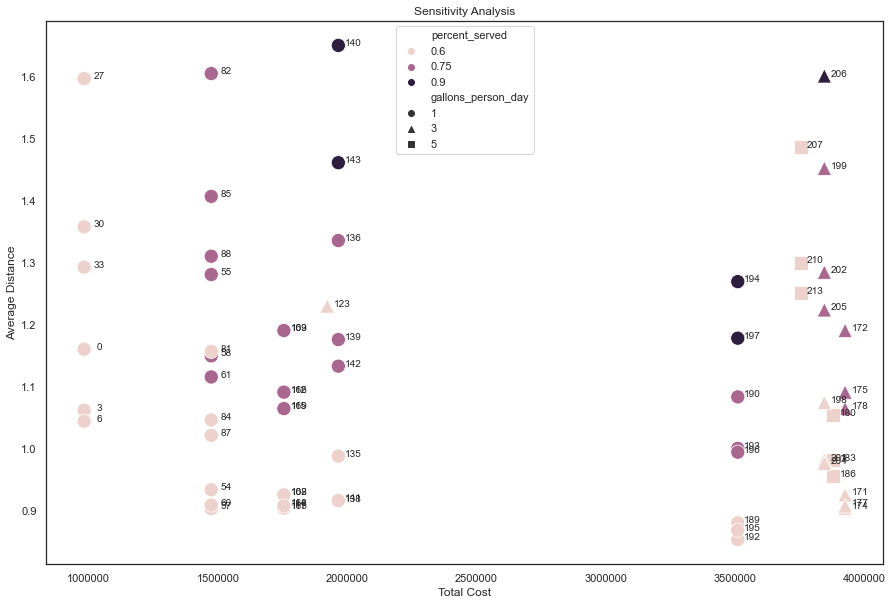

In [30]:
#plot cost vs. avg distance
sns.set(style = "white", rc = {'figure.figsize':(15, 10)})

fig, ax = plt.subplots()

sns.scatterplot(data = graph_sa_3, x = 'cost', y = 'distavg', hue = 'percent_served', 
                style = 'gallons_person_day', s = 200, markers = ['o', '^', 's'], legend = 'full')

plt.ticklabel_format(style = 'plain', axis = 'x')

plt.title('Sensitivity Analysis')
plt.xlabel('Total Cost')
plt.ylabel('Average Distance')
plt.legend(loc = 'upper center')

for i in range(len(graph_sa_3['key'])):
    plt.annotate(str(graph_sa_3['key'].iloc[i]), 
                 (graph_sa_3['cost'].iloc[i], graph_sa_3['distavg'].iloc[i]),
                 textcoords = "offset points",
                 xytext = (15, 0),
                 ha = 'center',
                 size = 10)
        
plt.show()

### Visualize Allegheny County Map With Water Plan

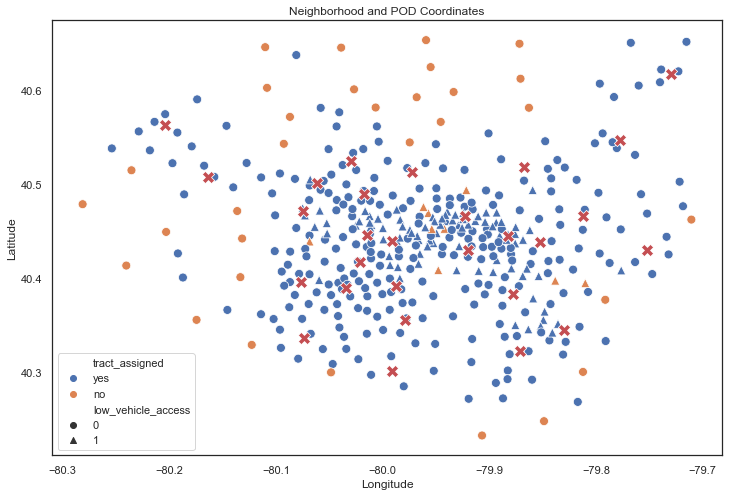

In [31]:
# medium cost, medium/high distance, 90%
results = pods_with_budget_3[143]

##prep data for plot
#pods built
[pod_results] = list(results[6].values())
graph_pods_3 = pd.DataFrame(pod_results).set_index(0).join(pod_coords_full, how = 'inner').reset_index(drop = True)

#neighborhoods served
[dl] = list(results[8].values())
tract_results = [i[0] for i in dl]
graph_tracts_3 = (pd.DataFrame(tract_results).set_index(0)).merge(tract_coords, 
                                                                  how = 'right', 
                                                                  left_index = True, 
                                                                  right_index = True, 
                                                                  indicator = True)

def tract_assign(r):
    if r['_merge'] == 'right_only':
        return 'no'
    if r['_merge'] == 'both':
        return 'yes'
graph_tracts_3['tract_assigned'] = graph_tracts_3.apply(tract_assign, axis = 1)

##plot
sns.set(style = "white", rc = {'figure.figsize':(12,8)})

fig, ax = plt.subplots()

sns.scatterplot(data = graph_tracts_3, x = 'intptlong', y = 'intptlat', hue = 'tract_assigned', 
                hue_order = ['yes', 'no'], style = 'low_vehicle_access', markers = ['o', '^'], ax = ax, s = 80)
sns.scatterplot(data = graph_pods_3, x = 'long', y = 'lat', marker = 'X', ax = ax, color = 'r', s = 150)

plt.title('Neighborhood and POD Coordinates')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

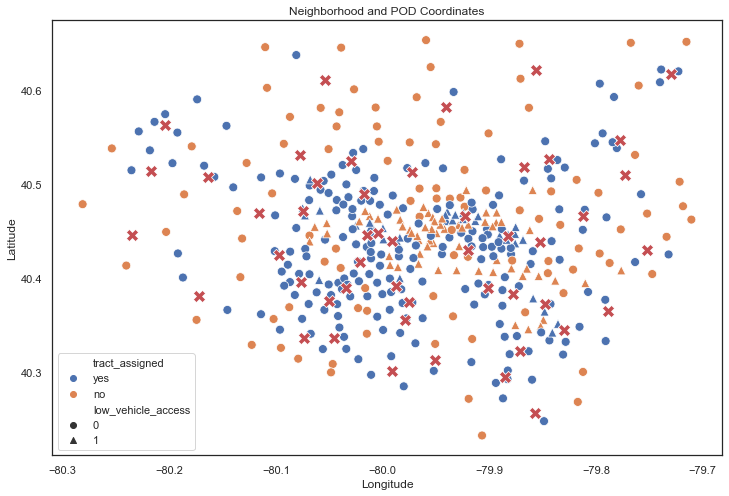

In [32]:
# high cost, low distance, 3 gallons/person/day
results = pods_with_budget_3[171]

##prep data for plot
#pods built
[pod_results] = list(results[6].values())
graph_pods_3 = pd.DataFrame(pod_results).set_index(0).join(pod_coords_full, how = 'inner').reset_index(drop = True)

#neighborhoods served
[dl] = list(results[8].values())
tract_results = [i[0] for i in dl]
graph_tracts_3 = (pd.DataFrame(tract_results).set_index(0)).merge(tract_coords, 
                                                                  how = 'right', 
                                                                  left_index = True, 
                                                                  right_index = True, 
                                                                  indicator = True)

def tract_assign(r):
    if r['_merge'] == 'right_only':
        return 'no'
    if r['_merge'] == 'both':
        return 'yes'
graph_tracts_3['tract_assigned'] = graph_tracts_3.apply(tract_assign, axis = 1)

##plot
sns.set(style = "white", rc = {'figure.figsize':(12,8)})

fig, ax = plt.subplots()

sns.scatterplot(data = graph_tracts_3, x = 'intptlong', y = 'intptlat', hue = 'tract_assigned',
                hue_order = ['yes', 'no'], style = 'low_vehicle_access', markers = ['o', '^'], ax = ax, s = 80)
sns.scatterplot(data = graph_pods_3, x = 'long', y = 'lat', marker = 'X', ax = ax, color = 'r', s = 150)

plt.title('Neighborhood and POD Coordinates')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

### Visualize Travel Distances

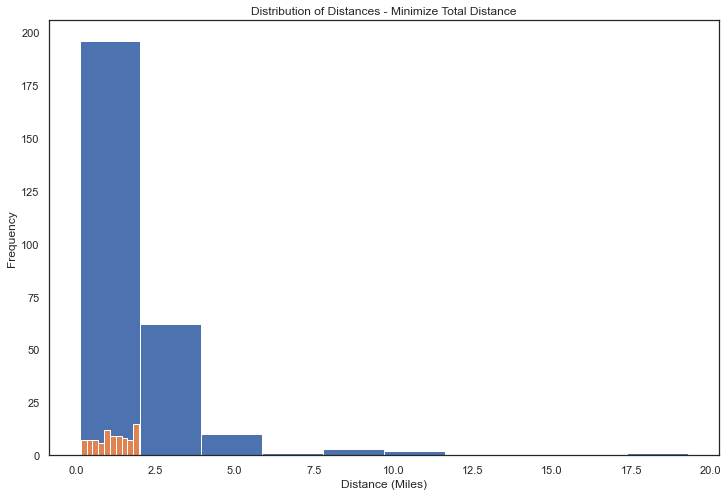

In [33]:
# medium cost, medium/high distance, 90%
results = pods_with_budget_3[143]

#tracts
[dl] = list(results[8].values())
tract_results = [i[0] for i in dl]
#distances
[dist_results] = list(results[10].values())

graph_tracts_td_3 = (pd.DataFrame({'tract': tract_results, 
                                   'dist': dist_results})).merge(tract_coords[['low_vehicle_access']], 
                                                                 how = 'left', 
                                                                 left_on = 'tract', 
                                                                 right_index = True, 
                                                                 indicator = True)

plt.figure()

plt.hist(graph_tracts_td_3[graph_tracts_td_3['low_vehicle_access'] == 0]['dist'])
plt.hist(graph_tracts_td_3[graph_tracts_td_3['low_vehicle_access'] == 1]['dist'])

plt.title('Distribution of Distances - Minimize Total Distance')
plt.xlabel('Distance (Miles)')
plt.ylabel('Frequency')

plt.show()

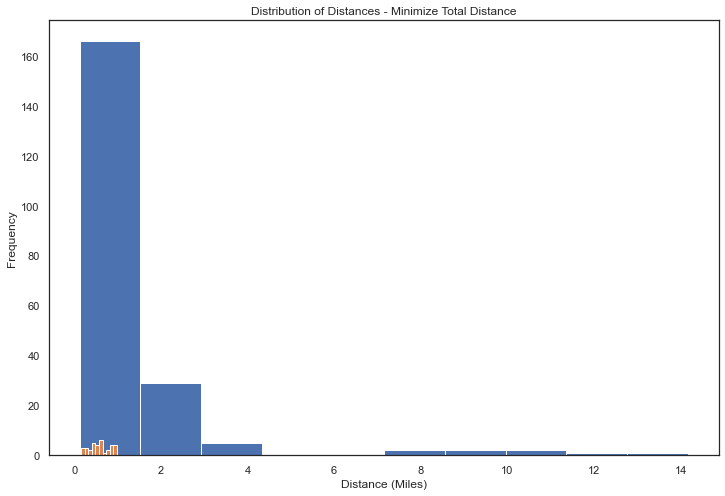

In [34]:
# high cost, low distance, 3 gallons/person/day
results = pods_with_budget_3[171]

#tracts
[dl] = list(results[8].values())
tract_results = [i[0] for i in dl]
#distances
[dist_results] = list(results[10].values())

graph_tracts_td_3 = (pd.DataFrame({'tract': tract_results, 
                                   'dist': dist_results})).merge(tract_coords[['low_vehicle_access']], 
                                                                 how = 'left', 
                                                                 left_on = 'tract', 
                                                                 right_index = True, 
                                                                 indicator = True)

plt.figure()

plt.hist(graph_tracts_td_3[graph_tracts_td_3['low_vehicle_access'] == 0]['dist'])
plt.hist(graph_tracts_td_3[graph_tracts_td_3['low_vehicle_access'] == 1]['dist'])

plt.title('Distribution of Distances - Minimize Total Distance')
plt.xlabel('Distance (Miles)')
plt.ylabel('Frequency')

plt.show()